# Explore spatial averaging on IEC validation panel antenna

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 1/2/2023

+ FEKO data provided by Danie Ludick
+ Uses **v11** RFcalcUC module
+ This notebook uses dataframes in HDF5 files that were generated from the `make_HDF5_MBS_panel_trial2.ipynb` notebook

## Load necessary python modules

In [8]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
from copy import deepcopy
import textwrap as tr
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

# PARAMETERS
  # Set limit values at 900 MHz
SLIM_WB_PUB = 4.5  # W/m²
SARLIM_PUB = 0.08  # W/kg
  # Letters
LETTERS = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

## Look at model metadata for the spatial averaging trials

In [9]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials.loc[:,['unit','2','3']]

unit                                                  2  \
INPUT                                                                       
fMHz               MHz                                                900   
antenna                                           IEC 62232 panel antenna   
Prad                 W                                                200   
dBiGain                                                                     
horizHPBW          deg                                                      
vertHPBW           deg                                                      
coordinate_origin                       centre of the middle feed segment   
xstart               m                                                 -1   
xend                 m                                                 14   
dx                   m                                                0.1   
ystart               m                                                 -7   
yend                 m                                                  7   
dy                   m                                                0.1   
zstart               m                                                 -3   
zend                 m                                                  3   
dz                   m                                                0.1   
bearing            deg                             main beam along x axis   
antenna_folder                                                 MBSpanel_2   
FEKO_Efile              IEC-62232-panel-antenna-NearField_NearField.ef...   
FEKO_Hfile              IEC-62232-panel-antenna-NearField_NearField.hf...   
SAR_file                           IEC_Panel_antenna_wbSAR-2022-12-15.csv   
Notes                   Updated phantom with proper size and dielectri...   

                                                                   3  
INPUT                                                                 
fMHz                                                             900  
antenna                                                         Yagi  
Prad                                                             100  
dBiGain                                                               
horizHPBW                                                             
vertHPBW                                                              
coordinate_origin                           centre of rear reflector  
xstart                                                            -1  
xend                                                               5  
dx                                                               0.1  
ystart                                                            -2  
yend                                                               2  
dy                                                               0.1  
zstart                                                            -3  
zend                                                               3  
dz                                                               0.1  
bearing                                       main beam along x axis  
antenna_folder                                                 Hyagi  
FEKO_Efile         yagi_horizontal_900Mhz_100W_NearFieldforSAR.ef...  
FEKO_Hfile         yagi_horizontal_900Mhz_100W_NearFieldforSAR.hf...  
SAR_file                         horizontalYagi-wbSAR-2022-12-15.csv  
Notes                                                Horizontal Yagi

## Create the RFc object for the analyses
The class for this object is in the `RFcalcUC_v11.py` file

In [10]:
# Set trial number
trial = 2
t = trials[str(trial)]

In [11]:
# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)
R

datadir = '../antennas/MBSpanel_2/data/'
plotdir = '../antennas/MBSpanel_2/plots/'


Object parameters:
  900 MHz, 200 W
  errtol = 0.15
  offset = 0 m
  default length of spatial averagering window = 1.6 m
  1,298,751 grid points
  nx = 151, ny = 141, nz = 61

In [12]:
# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print(*R.grid.items(),sep='\n')

Sfile='../antennas/MBSpanel_2/data/MBSpanel_2.hdf5'


x    y    z         r        phi        SE        SH      Smax  SARwb  \
0 -1.0 -7.0 -3.0  7.071068 -98.130102  0.007138  0.007219  0.007219    NaN   
1 -1.0 -7.0 -2.9  7.071068 -98.130102  0.007635  0.007725  0.007725    NaN   
2 -1.0 -7.0 -2.8  7.071068 -98.130102  0.007646  0.007729  0.007729    NaN   
3 -1.0 -7.0 -2.7  7.071068 -98.130102  0.007189  0.007244  0.007244    NaN   
4 -1.0 -7.0 -2.6  7.071068 -98.130102  0.006404  0.006415  0.006415    NaN   

   SARwbi  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}

('x', [-1, 14, 0.1])
('y', [-7, 7, 0.1])
('z', [-3, 3, 0.1])


## Create filter masks
**Criteria for a valid assessment point**

+ The point must lie outside the offsetted antenna box
+ The point must not lie within spatavgL/2 of the upper and lower z bounds for all S points
+ The point must not lie within spatavgL/2 of the upper and lower z bounds of the antenna box

In [13]:
f = R.sf('near field', offset=1, spatavgL=1.6, data='Smax')
RFcalcUC.show_grid_points(R.S[f.mask], fields=['Smax'],hman=None,axv=(True,True,True), ycut=True,
                          antcolor='yellow',bgcolor='white',antenna=RFcalcUC.panelAntenna,title=f.name)
f

*Filter object*
              name: Valid near field points within 1m of antenna box
No. of mask points: 20,652
                 m: near field
            offset: 1
          spatavgL: 1.6
            errtol: 0.15
             power: 200

In [14]:
# Calculate wavelength, λ
wl = 300 / R.freq
d = round(wl, 3)

# valid Smax points within 1λ of antenna (near field)
f_near = R.sf('near field', offset=d, spatavgL=0)

# valid 1.6m spatial averaging points within 1λ of antenna (near field)
f_near_sa16 = R.sf('near field', offset=d, spatavgL=1.6)

# valid Smax points further than one λ from antenna (far field)
f_far = R.sf('valid', offset=d, spatavgL=0)

# valid Smax points further than one λ from antenna (far field)
f_far_sa16 = R.sf('valid', offset=d, spatavgL=1.6)

# all valid Smax points
f_Smax = R.sf('valid', offset=0.001, spatavgL=0)

# all valid 1.6m spatial averaging points
f_sa16 = R.sf('valid', offset=0.001, spatavgL=1.6)

# all valid 2.0m spatial averaging points
f_sa20 = R.sf('valid', offset=0.001, spatavgL=2.0)

# all valid 0.6m spatial averaging points
f_sa06 = R.sf('valid', offset=0.001, spatavgL=0.6)

# all points outside antenna box
f_outant = R.sf('outant', offset=0.001)

def make_16m_cb_filter(Si, errtol, power):
    '''Create a filter for valid 1.6m spatially averaged points
       where Si is within the error tolerance of the public limit
       for the nominated radiated power of the antenna'''
    f_sa16_cb = deepcopy(f_sa16)
    f_cb = R.sf('cb', setting='pub', data=Si, offset=0.001,
                errtol=errtol, spatavgL=1.6, power=power, standard='RPS S-1 WB')
    f_sa16_cb.mask = f_sa16_cb.mask & f_cb.mask
    f_sa16_cb.name = f'{f_sa16_cb.name} near {power}W compliance boundary'
    return f_sa16_cb

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 200W radiated power
f_sa16_cb200W = make_16m_cb_filter('Smax', 0.15, 200)

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 150W radiated power
f_sa16_cb150W = make_16m_cb_filter('Smax', 0.15, 150)

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 100W radiated power
f_sa16_cb100W = make_16m_cb_filter('Smax', 0.15, 100)

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 50W radiated power
f_sa16_cb50W = make_16m_cb_filter('Smax', 0.15, 50)

# SARwbi grid
f_SARwbi = deepcopy(f_sa16)
SARwbi_mask = ~R.S.SARwbi.isnull()
f_SARwbi.mask = f_SARwbi.mask & SARwbi_mask
f_SARwbi.name = "valid points in SARwbi grid box of points"

### Show filtered grid points

In [8]:
# Show mask points
# f = f_near
# f = f_outant
# f = f_sa16
f = f_SARwbi
print(f.name)
# RFcalcUC.show_grid_points(R.S[f.mask], fields=['SE'],hman=None,axv=(True,True,True), ycut=True,
#                           antcolor='yellow',bgcolor='white',antenna=RFcalcUC.panelAntenna,title=f.name)

valid points in SARwbi grid box of points


## Data checks

### Show SAR and S grids

In [9]:
# RFcalcUC.show_grid_points(R.S, fields=['SARwb'], ycut=True, antenna=RFcalcUC.panelAntenna)

### Check interpolated SARwbi values

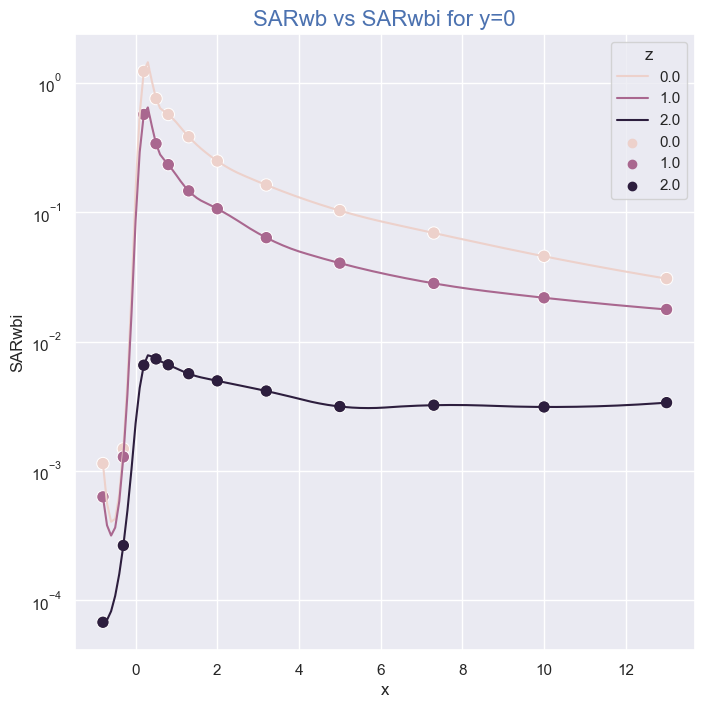

In [172]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
ym = 0
mask = (R.S.y == ym) & (R.S.z.isin([0,1,2]))

sn.lineplot(data=R.S[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=R.S[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_title(f'SARwb vs SARwbi for y={ym}', fontsize=16, color='b');

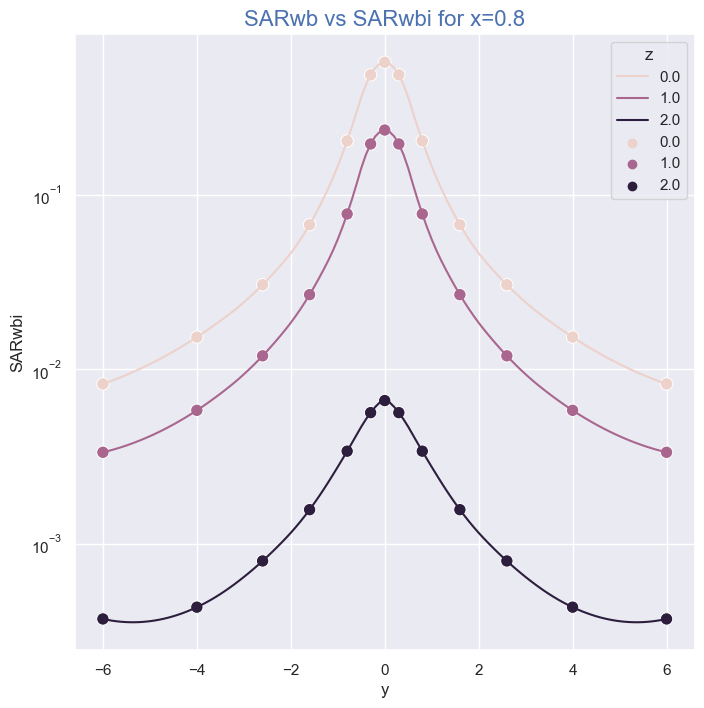

In [173]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
xm = 0.8
mask = (R.S.x == xm) & (R.S.z.isin([0,1,2]))

sn.lineplot(data=R.S[mask],x='y',y='SARwbi',hue='z')
sn.scatterplot(data=R.S[mask],x='y',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_title(f'SARwb vs SARwbi for x={xm}', fontsize=16, color='b');

### View public and occ compliance zones

In [174]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.ExclusionZone(
    data=["SE", "SE"],
    power=[200, 200],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    axv=[True,False,True]
)

dat='SE', con=4.5
dat='SE', con=22.5
[-0.1, 12.8, -5.8, 5.8, -1.3, 1.3]
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500
power=200, plotpower=200, setting=occupational, limit=22.5 W/m², contour level=22.500


In [23]:
# Animated 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.AnimatedExclusionZone(
    data=["SE", "SE"],
    power=[50, 50],
    color=["gold", "red"],
    alpha=[0.5, 0.5],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    ycut=0,
    daz=-0.1,
    elevation = 80,
    distance=None,
    title="",
    figsize=(1200,800),
    antenna=RFcalcUC.panelAntenna,
    axv=[False,False,False]
)

dat='SE', con=18.0
dat='SE', con=90.0
power=200, plotpower=50, setting=public, limit=4.5 W/m², contour level=18.000
power=200, plotpower=50, setting=occupational, limit=22.5 W/m², contour level=90.000


In [13]:
# 3D view of public exclusion zone (200W) with gridpoints visible
R.ExclusionZone(
    data=["SE"],
    power=[200, 200],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    gridpoints=True,
    axv=[True,True,False]
)

dat='SE', con=4.5
[-0.1, 12.8, -5.8, 5.8, -1.3, 1.3]
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500


## Create spatially averaged fields
Create some new S columns for vertical spatial averaging

**c** is the convolution vector applied to z columns of points for each (x,y) group

For **Simpson's 1/3 rule**, the number of subintervals must be a multiple of **2**

For **Simpson's 3/8 rule**, the number of subdivisions must be divisible by **3**

In [15]:
def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

In [16]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
for m in [17,9,5,3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
creating SE-1.6m-17 spatial average of SE
creating Smax-1.6m-17 spatial average of Smax

 9 points: sum[0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111] = 1.0000000000000002
creating SE-1.6m-9 spatial average of SE
creating Smax-1.6m-9 spatial average of Smax

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating SE-1.6m-5 spatial average of SE
creating Smax-1.6m-5 spatial average of Smax

 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-1.6m-3 spatial average of SE
creating Smax-1.6m-3 spatial average of Smax


In [17]:
# 1.6m vertical average curves using Simpsons 1/3 rule
l = 1.6
c17 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c9  = [1,0,4,0,2,0,4,0,2,0,4,0,2,0,4,0,1]
c3  = [1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1]
for m,clist in zip([3,5,9,17],[c3,c5,c9,c17]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}-S13", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
    R.spatavg(f"Smax-{l}m-{m}-S13", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3))")


 3 points: sum[0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167] = 0.9999999999999999
creating SE-1.6m-3-S13 spatial average of SE
creating Smax-1.6m-3-S13 spatial average of Smax

 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-1.6m-5-S13 spatial average of SE
creating Smax-1.6m-5-S13 spatial average of Smax

 9 points: sum[0.042, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.042] = 0.9999999999999999
creating SE-1.6m-9-S13 spatial average of SE
creating Smax-1.6m-9-S13 spatial average of Smax

17 points: sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating SE-1.6m-17-S13 spatial average of SE
creating Smax-1.6m-17-S13 spatial average of Smax


In [18]:
# 1.6m vertical average curves using Simpsons 1/3 rule and SH
l = 1.6
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
for m,clist in zip([5],[c5]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SH-{l}m-{m}-S13", "SH", c, title=f"FEKO SH levels ({m} points averaged over {l}m (Simpson 1/3))")


 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SH-1.6m-5-S13 spatial average of SH


In [19]:
# 1.5m vertical average curves using Simpsons 3/8 rule on 7 points
# Note: had to approximate values at 0.25,0.75,1.25 with 
# averages of (0.2,0.3), (0.7,0.8), (1.2,1.3)
l = 1.5
m = 7
dl = l / (m-1)
#      0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5
c6  = [1, 0, 1.5,1.5, 0,  3,  0,  1,  1,  0,  3,  0, 1.5,1.5, 0,  1]
c = (3/8)*(dl/l) * np.array(c6)
print(f'\n{m:2d} points: sum{list(c)} = {sum(c)}')
R.spatavg(f"SE-{l}m-{m}-S38", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 3/8))")
R.spatavg(f"Smax-{l}m-{m}-S38", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 3/8))")


 7 points: sum[0.0625, 0.0, 0.09375, 0.09375, 0.0, 0.1875, 0.0, 0.0625, 0.0625, 0.0, 0.1875, 0.0, 0.09375, 0.09375, 0.0, 0.0625] = 1.0
creating SE-1.5m-7-S38 spatial average of SE
creating Smax-1.5m-7-S38 spatial average of Smax


In [20]:
# 2m vertical average curves
# l, dl = 2, 0.1
# for m in [21]:
#     c = conv_vector(l, dl, m)
#     print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
#     R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
#     R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


21 points: sum[0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048] = 1.0000000000000004
creating SE-2m-21 spatial average of SE
creating Smax-2m-21 spatial average of Smax


In [21]:
# 2m vertical average curves using Simpsons 1/3 rule on 5 points
# l = 2
# m = 5
# dl = l / (m-1)
# #     0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0
# c7 = [1, 0,  0,  0,  0,  4,  0,  0,  0,  0,  2,  0,  0,  0,  0,  4,  0,  0,  0,  0,  1]
# c = (1/3)*(dl/l) * np.array(c7)
# print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
# R.spatavg(f"SE-{l}m-{m}",  "SE",  c,title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
# R.spatavg(f"Smax-{l}m-{m}","Smax",c,title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3)")


 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-2m-5 spatial average of SE
creating Smax-2m-5 spatial average of Smax


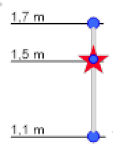

In [22]:
# IEC 62232 spatial averaging scheme (3pts over 0.6m)
c = np.array([1,0,0,0,1,0,1,0,0]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-0.6m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 0.6m)")
R.spatavg(f"Smax-IEC-0.6m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 0.6m)")

len(c) = 9 points: sum[0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333, 0.0, 0.0] = 1.0
creating SE-IEC-0.6m-3 spatial average of SE
creating Smax-IEC-0.6m-3 spatial average of Smax


In [23]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-9': 'FEKO SE levels (9 points averaged over 1.6m)',
 'Smax-1.6m-9': 'FEKO Smax levels (9 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.6m-3-S13': 'FEKO SE levels (3 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-3-S13': 'FEKO Smax levels (3 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-5-S13': 'FEKO SE levels (5 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-5-S13': 'FEKO Smax levels (5 points averaged over 1.6m (Simpson 1/3))',


## Create compliance boundary filters

In [24]:
# Calculate equivalent limits for 200W pub and 50W occ
Slim_highpower_pub = SLIM_WB_PUB
Slim_lowpower_occ =  SLIM_WB_PUB * 5 * (200/50)

def cb_filter(Si):
    f = deepcopy(f_sa16)
    mask = (R.S[Si] >= Slim_highpower_pub) & (R.S[Si] <= Slim_lowpower_occ)
    f.mask = f.mask & mask
    f.name = f'valid points between {Si} pub & occ compliance boundaries for 50<=power<=200W'
    return f

f_Smax_cb50to200W = cb_filter('Smax')
f_Smax_cb50to200W_sa16_17_S13 = cb_filter('Smax-1.6m-17-S13')
f_Smax_cb50to200W_sa16_9_S13 = cb_filter('Smax-1.6m-9-S13')
f_Smax_cb50to200W_sa16_5 = cb_filter('Smax-1.6m-5')
f_Smax_cb50to200W_sa16_3 = cb_filter('Smax-1.6m-3')
f_Smax_cb50to200W_sa16_5_S13 = cb_filter('Smax-1.6m-5-S13')
f_Smax_cb50to200W_sa16_3_S13 = cb_filter('Smax-1.6m-3-S13')

f_SE_cb50to200W = cb_filter('SE')
f_SE_cb50to200W_sa16_17_S13 = cb_filter('SE-1.6m-17-S13')
f_SE_cb50to200W_sa16_9_S13 = cb_filter('SE-1.6m-9-S13')
f_SE_cb50to200W_sa16_5 = cb_filter('SE-1.6m-5')
f_SE_cb50to200W_sa16_3 = cb_filter('SE-1.6m-3')
f_SE_cb50to200W_sa16_5_S13 = cb_filter('SE-1.6m-5-S13')
f_SE_cb50to200W_sa16_3_S13 = cb_filter('SE-1.6m-3-S13')

## Compare compliance zones

R essentially indicates the level of over-estimating WBA SAR compliance when conforming with the S limits. R ≥ 1 at an assessment point implies that WBA SAR will be compliant if S is compliant at that point and so it is desirable that R is always greater than or equal to 1.

#### WBA SAR vs all S settings

In [35]:
# Compare SAR, Smax
n = 6
R.ExclusionZone(
    data=["SARwbi","Smax","Smax-1.6m-17","Smax-1.6m-5","Smax-1.6m-3","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","lightgrey","green","blue","brown","olive"],
    alpha=[1,0.5,0.5,0.5,0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs S compliance zones",
    ycut=0,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax', con=11.25
dat='Smax-1.6m-17', con=11.25
dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-3', con=11.25
dat='Smax-IEC-0.6m-3', con=11.25
[0.0, 7.5, -3.1, 3.1, -1.9, 1.9]
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs peak spatial Smax

In [13]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax"],
    power=[80] * n,
    color=["magenta","lightgrey"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### SE spatial average 2m over 3pts

In [32]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["Smax-2m-3","Smax-2m-3"],
    power=[200]*2,
    color=["yellow","red"],
    alpha=[0.5]*2,
    setting=["public","occ"],
    standard=["RPS S-1 WB"]*2,
    title="SE-2m-3 public and occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=4.5
dat='Smax-2m-3', con=22.5
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500
power=200, plotpower=200, setting=occ, limit=22.5 W/m², contour level=22.500


In [33]:
# Compare SAR, Ssa 1.6m 17pts
n = 1
R.ExclusionZone(
    data=["Smax-2m-3"],
    power=[200],
    color=["red"],
    alpha=[0.5],
    setting=["occ"],
    standard=["RPS S-1 WB"],
    title="SE-2m-3 occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=22.5
power=200, plotpower=200, setting=occ, limit=22.5 W/m², contour level=22.500


#### WBA SAR vs Smax spatial average 1.6m over 17pts

In [33]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-17', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs Smax spatial average 1.6m over 5pts

In [16]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [10]:
# Show Ssa 1.6m 17pts for GitBook image
n = 1
R.ExclusionZone(
    data=["Smax-1.6m-17"],
    power=[80] * n,
    color=["blue"] * n,
    alpha=[0.4] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Gitbook image of compliance zone",
    ycut=None,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-17', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [11]:
# Show Smax for GitBook image
n = 1
R.ExclusionZone(
    data=["Smax"],
    power=[80] * n,
    color=["lightgrey"] * n,
    alpha=[0.5] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Gitbook image of compliance zone",
    ycut=None,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [15]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
n = 2
R.AnimatedExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.3],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    ycut=None,
    daz=-0.2,
    elevation = 60,
    distance=None,
    title="",
    showtitle=True,
    figsize=(900,900),
    antenna=RFcalcUC.panelAntenna,
    axv=[False,False,False],
    bg='lightgrey',
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs Smax spatial average 1.6m over 3pts

In [41]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-3', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs SE spatial average 1.6m over 5pts

In [18]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","SE-1.6m-5"],
    power=[100] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs SE-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.16
dat='SE-1.6m-5', con=9.0
power=200, plotpower=100, setting=public, limit=0.08 W/kg, contour level=0.160
power=200, plotpower=100, setting=public, limit=4.5 W/m², contour level=9.000


#### WBA SAR vs Smax IEC spatial average 0.6m over 3pts

In [40]:
# Compare SAR, Smax 1.6m 17pts Simpson
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17S"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-17S', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [42]:
# Compare Smax 1.6m 5pts, Smax 1.6m 17pts Simpson
n = 2
R.ExclusionZone(
    data=["Smax-1.6m-17","Smax-1.6m-17S"],
    power=[80] * n,
    color=["blue","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-17', con=11.25
dat='Smax-1.6m-17S', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [43]:
# Compare Smax 1.6m 5pts, Smax 1.6m 5pts Simpson
n = 2
R.ExclusionZone(
    data=["Smax-1.6m-5","Smax-1.6m-5S"],
    power=[80] * n,
    color=["blue","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-5S', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### Simpsons 1/3 rule compliance zones for 1.6m

In [123]:
# Compare SAR, Smax_sa, Smax_sa_S13 1.6m 17pts 80W
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17","Smax-1.6m-17-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 using Simpsons 1/3 rule",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-17', con=11.25
dat='Smax-1.6m-17-S13', con=11.25
[0.0, 5.5, -2.1, 2.1, -1.8, 1.8]
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [125]:
# Compare SAR, Smax_sa, Smax_sa_S13 1.6m 5pts 80W
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5", "Smax-1.6m-5-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 using Simpsons 1/3 rule",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-5-S13', con=11.25
[0.0, 5.4, -2.0, 2.0, -1.8, 1.8]
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [127]:
# Compare SAR, SEsa 1.6m 5pts
n = 3
R.ExclusionZone(
    data=["SARwbi", "Smax-1.6m-5-S13","Smax-1.6m-17-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs 5-pt and 17-pt spatially averaged Smax using Simpsons 1/3 rule",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5-S13', con=11.25
dat='Smax-1.6m-17-S13', con=11.25
[0.0, 5.5, -2.1, 2.1, -1.8, 1.8]
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [209]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
n = 2
R.AnimatedExclusionZone(
    data=["SARwbi","Smax-1.6m-5-S13"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.3],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    ycut=None,
    daz=-0.2,
    elevation = 60,
    distance=None,
    title="",
    showtitle=True,
    figsize=(900,900),
    antenna=RFcalcUC.panelAntenna,
    axv=[False,False,False],
    bg='lightgrey',
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5-S13', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### Simpsons 3/8 rule compliance zones for 1.5m over 7 pts

In [62]:
# Compare SAR, SEsa 1.5m 7pts
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.5m-7-S38", "Smax-1.6m-5-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.3,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.5m-7 using Simpsons 3/8 rule",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.5m-7-S38', con=11.25
dat='Smax-1.6m-5-S13', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


## Compliance ratio for SARwbi

$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

### Create R columns

In [25]:
# create data columns for compliance ratio in R.S
Silist = ['Smax','Smax-IEC-0.6m-3','Smax-1.6m-17','Smax-1.6m-17-S13',
          'Smax-1.6m-3','Smax-1.6m-5','Smax-1.6m-3-S13','Smax-1.6m-5-S13',
          'Smax-1.6m-9-S13','SE-1.6m-5-S13','SH-1.6m-5-S13']
for Si in Silist:
    Rdata = (R.S[Si]/SLIM_WB_PUB) / (R.S['SARwbi']/SARLIM_PUB)
    name = f'R {Si}' 
    title = f'{Si} SARwbi compliance ratio'
    R.addS(Rdata, name, title)
    
# R.datatitles

### R histogram function

In [26]:
# Function to draw histograms of limit normalised ratios of Smax vs WBA SAR
def histR(sflist, dB=False, cols=2, power=''):    
    nS = len(sflist)
    rows = int(np.ceil(nS/cols))
    
    # Create labels for R or dB(R) cases
    if dB:
        xlabel = 'dB(R)'
        cisuffix = ' dB'
        bins = np.linspace(-3,6,51)                
    else:
        xlabel = 'R'
        cisuffix = ''
        bins = np.linspace(0,6,51)
        
    # Set the figsize according to number of rows
    if cols == 2:
        figsize = (10,18)
    elif cols == 3:
        figsize = (15,16)
    elif cols == 4:
        figsize = (18,10)
    else:
        figsize = (16,16)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows,cols,figsize=figsize,sharey=True)
    axes = axes.flatten()
    
    # Create histogram plots in axes 
    for i, (Si,f) in enumerate(sflist):
        # get R compliance ratio data
        # data = (R.S.loc[f.mask,Si]/SLIM_WB_PUB) / (R.S.loc[f.mask,'SARwbi']/SARLIM_PUB)
        Rcol = f'R {Si}'
        data = R.S.loc[f.mask,Rcol]
        if dB:
            data = 10. * np.log10(data)
        data = data.dropna()  # remove any nan values
            
        # plot histogram of data
        axes[i].hist(data,bins=bins,density=True)
        
        # set plot titles
        axes[i].set_title(Si, fontsize=15, color='g',fontweight="bold")
        if i % cols == 0:
            axes[i].set_ylabel('normalised counts',fontsize=14)
        axes[i].set_xlabel(xlabel, fontsize=14)
        
        # set x axis limits
        xmin, xmax = bins[0],bins[-1]
        axes[i].set_xlim(xmin,xmax)

        # print histogram statistics
        ci = np.percentile(data,[2.5,97.5]).round(2)
        mean = data.mean().round(2)
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}\n$\\mu$ = {mean}{cisuffix}' 
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}'
        
        # Adjust plots for dB or not dB
        if dB:
            axes[i].axvline(x=0, color='r',ls='--')
            axes[i].text(0.04, 0.9, text, horizontalalignment='left',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            text2 = tr.fill(f.name,width=25) + f'\n({len(data):,d} points)'
            axes[i].text(0.04, 0.82, text2, horizontalalignment='left',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=12, color='b')
        else:
            axes[i].axvline(x=1, color='r',ls='--')
            axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            text2 = tr.fill(f.name,width=25) + f'\n({len(data):,d} points)'
            axes[i].text(0.96, 0.84, text2, horizontalalignment='right',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=12, color='b')

        axes[i].text(0.08, 0.15, LETTERS[i], horizontalalignment='center', fontsize=18,
                     verticalalignment='center', transform=axes[i].transAxes)
        
    # Finish off decorating the figure
    if nS != rows * cols: axes[-1].remove()
    title = f'Limit normalised ratios of S vs WBA SAR:  ' +\
             '$R = \\frac{S/S_{lim}}{SAR/SAR_{lim}}$\n'
    if power != '':
        title = title + f'Radiated power = {power}W\n'
    fig.suptitle(title, fontsize=20)
    fig.tight_layout(h_pad=1)
    
def showstats(sflist, dB=False):
    table = []
    for i, (Si,f) in enumerate(sflist):
        Rcol = f'R {Si}'
        data = R.S.loc[f.mask,Rcol]
        data = data.dropna()  # remove any nan values
        dataname = ''
        if dB:
            data = 10. * np.log10(data)
            dataname = 'dB data'
        panel = LETTERS[i]
        count = len(data)
        ci = np.percentile(data,[2.5,50,97.5]).round(2)
        mean = data.mean().round(2)
        std = data.std().round(2)
        minval = data.min().round(2)
        maxval = data.max().round(2)
        table.append([panel,Si,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    df = pd.DataFrame(table,columns=('panel','Si','count','mean','std','min','2.5%','50%','97.5%','max'))
    df.columns.name = dataname
    
    return df.set_index('panel')

### R histograms

#### R histogram for valid points box of points

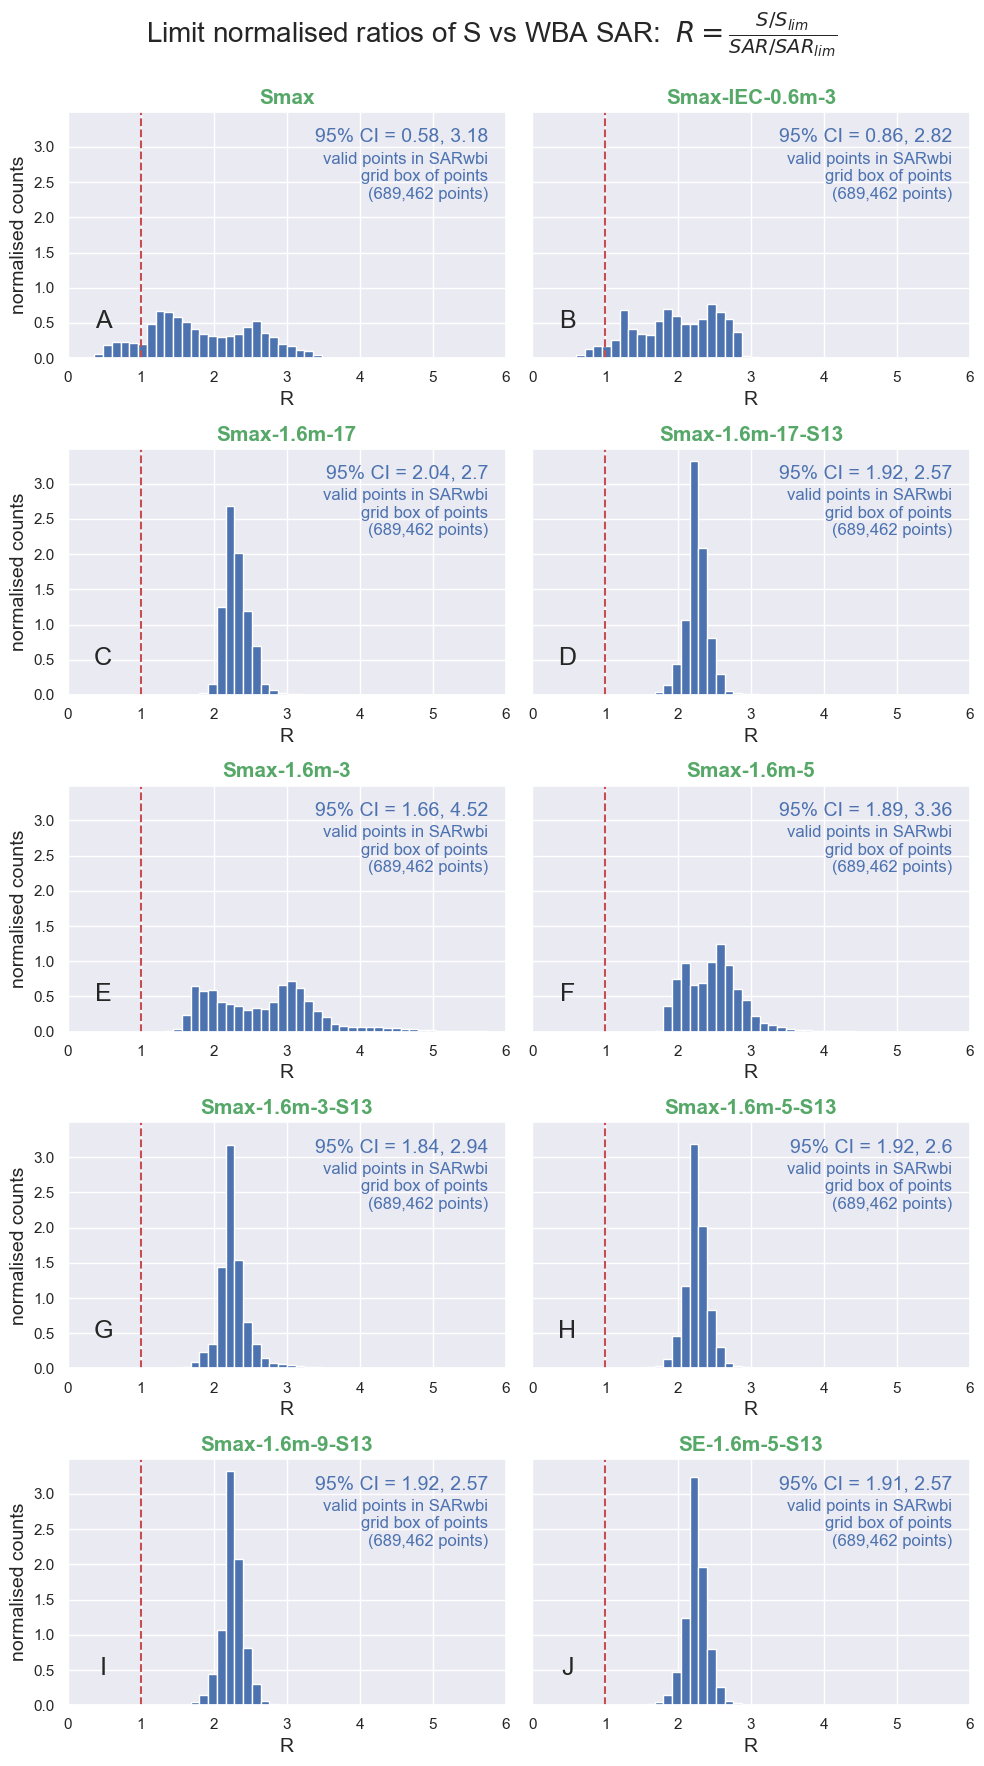

In [27]:
# Create list of fields and associated filters for R ratios
sflist = [['Smax',f_SARwbi],
          ['Smax-IEC-0.6m-3',f_SARwbi],
          ['Smax-1.6m-17',f_SARwbi],
          ['Smax-1.6m-17-S13',f_SARwbi],
          ['Smax-1.6m-3',f_SARwbi],
          ['Smax-1.6m-5',f_SARwbi],
          ['Smax-1.6m-3-S13',f_SARwbi],
          ['Smax-1.6m-5-S13',f_SARwbi],
          ['Smax-1.6m-9-S13',f_SARwbi],
          ['SE-1.6m-5-S13',f_SARwbi]]

f_SARwbi

# Generate histogram
histR(sflist,dB=False,cols=2)
plt.savefig(plotdir + 'R histogram panel.png', dpi=150)

In [54]:
showstats(sflist,dB=False)

Si   count  mean   std   min  2.5%   50%  97.5%     max
panel                                                                       
A                  Smax  689462  1.84  0.73  0.06  0.58  1.72   3.18   28.38
B       Smax-IEC-0.6m-3  689462  1.97  0.58  0.09  0.86  1.99   2.82   27.15
C          Smax-1.6m-17  689462  2.32  0.29  0.25  2.04  2.28   2.70   51.13
D      Smax-1.6m-17-S13  689462  2.26  0.26  0.25  1.92  2.24   2.57   41.77
E           Smax-1.6m-3  689462  2.72  0.97  0.16  1.66  2.74   4.52  204.92
F           Smax-1.6m-5  689462  2.49  0.54  0.20  1.89  2.49   3.36  123.27
G       Smax-1.6m-3-S13  689462  2.28  0.40  0.16  1.84  2.25   2.94  102.50
H       Smax-1.6m-5-S13  689462  2.26  0.27  0.18  1.92  2.24   2.60   51.77
I       Smax-1.6m-9-S13  689462  2.26  0.26  0.24  1.92  2.24   2.57   42.44
J         SE-1.6m-5-S13  689462  2.25  0.25  0.12  1.91  2.23   2.57   38.75

In [24]:
# Get proportion of R < 1 values for Smax on SARwbi grid
f = f_SARwbi
Si = 'Smax'
SmaxR = (R.S.loc[f.mask,Si]/SLIM_WB_PUB) / (R.S.loc[f.mask,'SARwbi']/SARLIM_PUB)
SmaxR = SmaxR.dropna()  # remove any nan values

nall = len(SmaxR)              # count of all not null R values
nlowR = len(SmaxR[SmaxR < 1])  # count of R values < 1
nlowR / nall

0.11777733943277512

#### dB(R) histograms for valid box of points

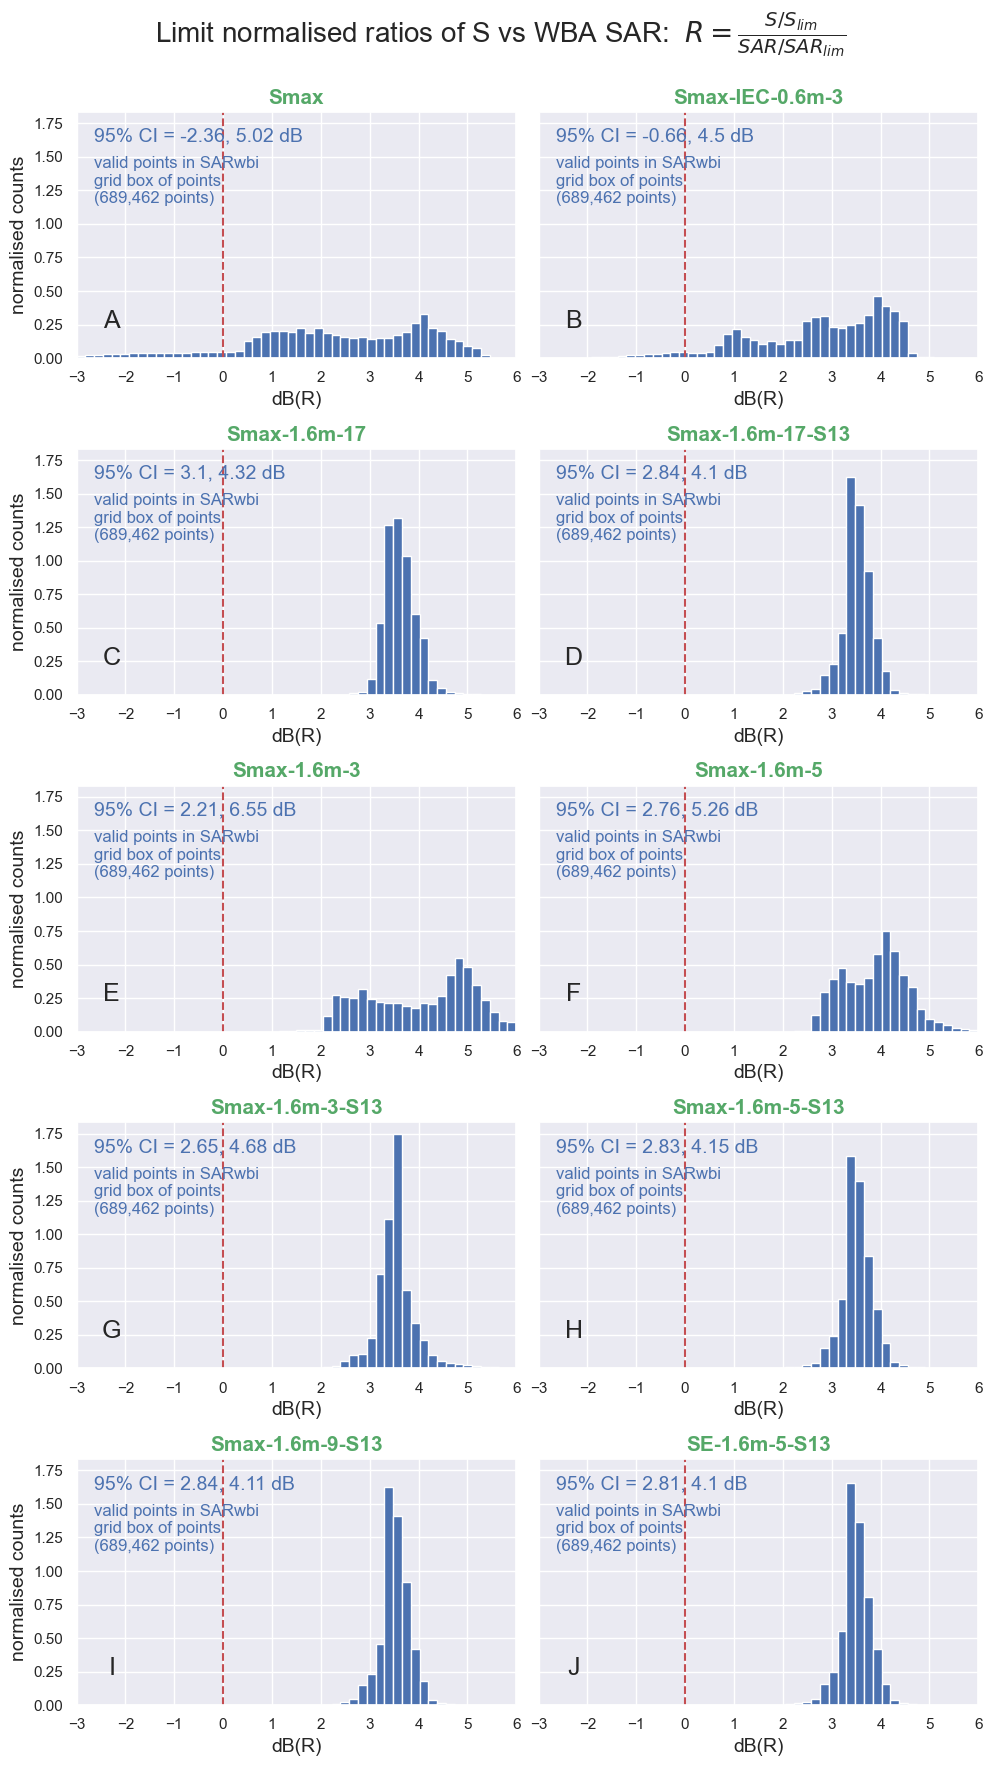

In [25]:
# dB(R) histograms for Slist
histR(sflist,dB=True,cols=2)
plt.savefig(plotdir + 'dB(R) histogram panel.png', dpi=150)

In [26]:
showstats(sflist,dB=False)

Si   count  mean   std   min  2.5%   50%  97.5%     max
panel                                                                       
A                  Smax  689462  1.84  0.73  0.06  0.58  1.72   3.18   28.38
B       Smax-IEC-0.6m-3  689462  1.97  0.58  0.09  0.86  1.99   2.82   27.15
C          Smax-1.6m-17  689462  2.32  0.29  0.25  2.04  2.28   2.70   51.13
D      Smax-1.6m-17-S13  689462  2.26  0.26  0.25  1.92  2.24   2.57   41.77
E           Smax-1.6m-3  689462  2.72  0.97  0.16  1.66  2.74   4.52  204.92
F           Smax-1.6m-5  689462  2.49  0.54  0.20  1.89  2.49   3.36  123.27
G       Smax-1.6m-3-S13  689462  2.28  0.40  0.16  1.84  2.25   2.94  102.50
H       Smax-1.6m-5-S13  689462  2.26  0.27  0.18  1.92  2.24   2.60   51.77
I       Smax-1.6m-9-S13  689462  2.26  0.26  0.24  1.92  2.24   2.57   42.44
J         SE-1.6m-5-S13  689462  2.25  0.25  0.12  1.91  2.23   2.57   38.75

#### R histograms for valid points in near field (<1$\lambda$)

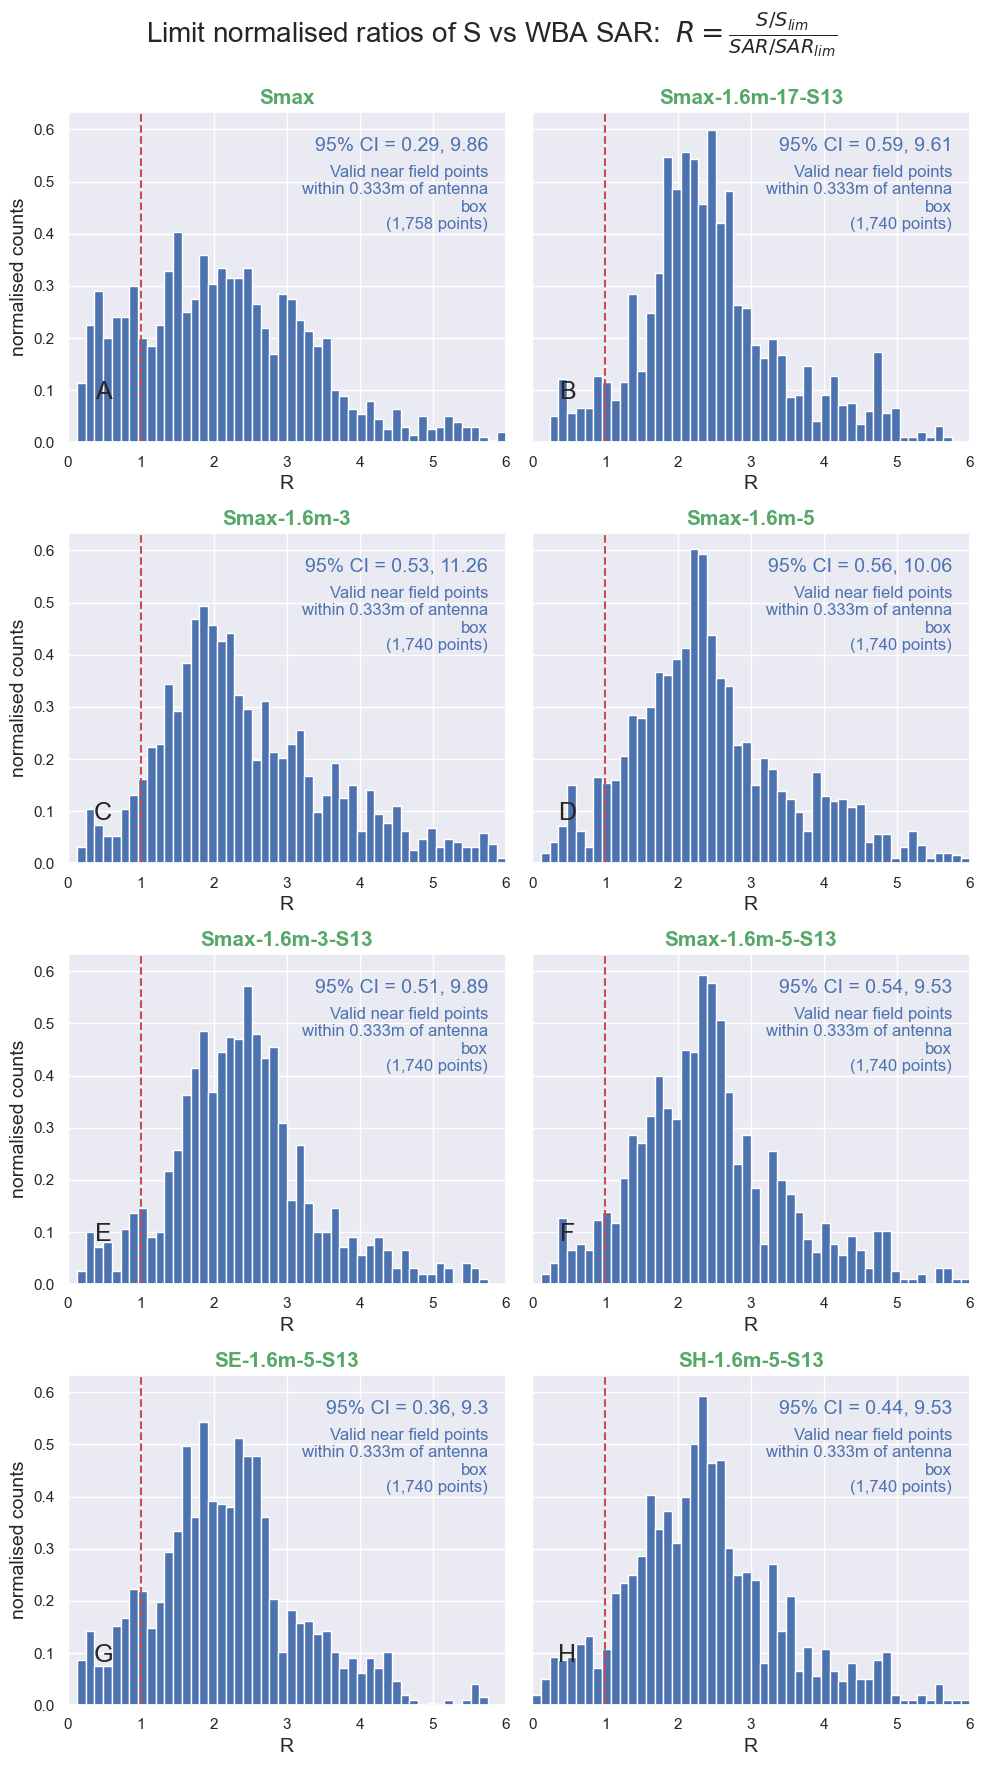

In [28]:
sflist = [['Smax',f_near],
          ['Smax-1.6m-17-S13',f_near_sa16],
          ['Smax-1.6m-3',f_near_sa16],
          ['Smax-1.6m-5',f_near_sa16],
          ['Smax-1.6m-3-S13',f_near_sa16],
          ['Smax-1.6m-5-S13',f_near_sa16],
          ['SE-1.6m-5-S13',f_near_sa16],
          ['SH-1.6m-5-S13',f_near_sa16]]

histR(sflist,dB=False,cols=2)
plt.savefig(plotdir + 'R histogram panel near.png', dpi=150)

In [28]:
showstats(sflist, dB=False)

Si  count  mean   std   min  2.5%   50%  97.5%    max
panel                                                                     
A                  Smax   1758  2.58  2.49  0.13  0.29  2.12   9.86  28.38
B      Smax-1.6m-17-S13   1740  2.95  2.38  0.25  0.59  2.41   9.61  22.37
C           Smax-1.6m-3   1740  3.08  2.83  0.16  0.53  2.30  11.26  33.63
D           Smax-1.6m-5   1740  3.05  2.73  0.20  0.56  2.36  10.06  33.79
E       Smax-1.6m-3-S13   1740  2.84  2.28  0.16  0.51  2.41   9.89  22.02
F       Smax-1.6m-5-S13   1740  2.98  2.61  0.18  0.54  2.41   9.53  34.40
G         SE-1.6m-5-S13   1740  2.68  2.45  0.12  0.36  2.21   9.30  27.52
H         SH-1.6m-5-S13   1740  2.88  2.48  0.09  0.44  2.35   9.53  32.85

#### R histograms for valid points in far field (> 1$\lambda$)

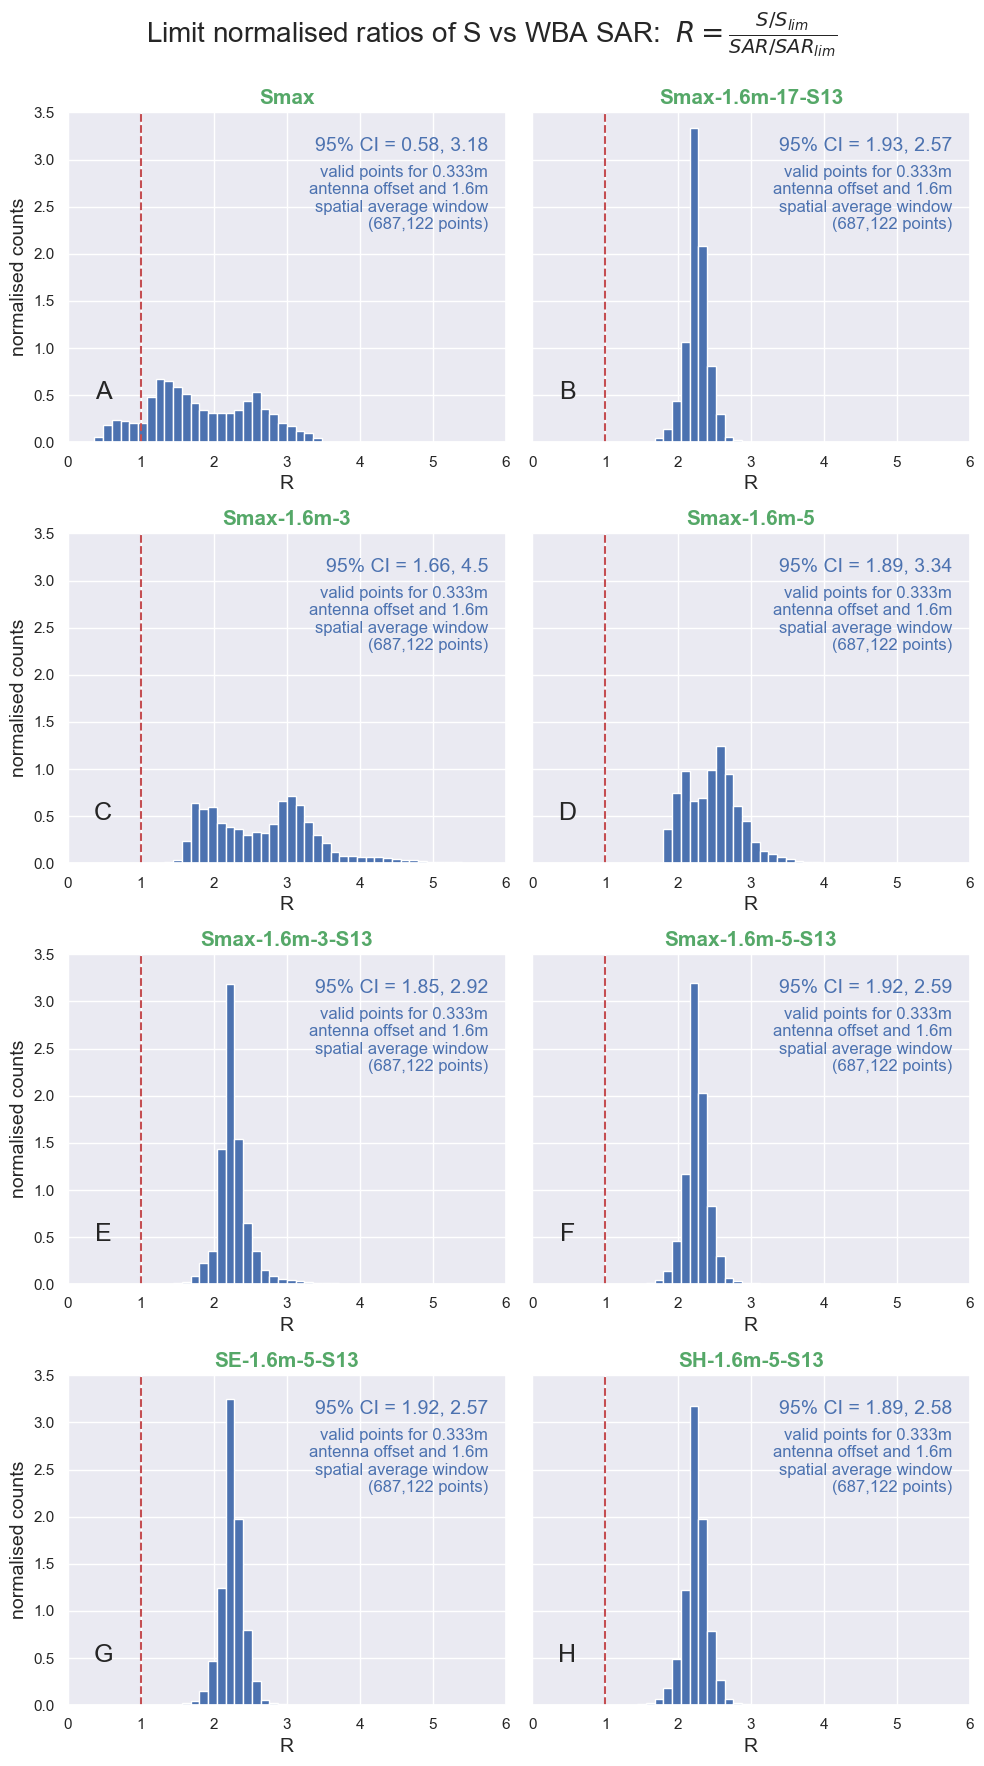

In [29]:
sflist = [['Smax',f_far_sa16],
          ['Smax-1.6m-17-S13',f_far_sa16],
          ['Smax-1.6m-3',f_far_sa16],
          ['Smax-1.6m-5',f_far_sa16],
          ['Smax-1.6m-3-S13',f_far_sa16],
          ['Smax-1.6m-5-S13',f_far_sa16],
          ['SE-1.6m-5-S13',f_far_sa16],
          ['SH-1.6m-5-S13',f_far_sa16]]

histR(sflist,dB=False,cols=2)
plt.savefig(plotdir + 'R histogram panel near.png', dpi=150)

#### R histograms for valid points near Smax compliance boundary

'R histogram panel cb 200W.png'

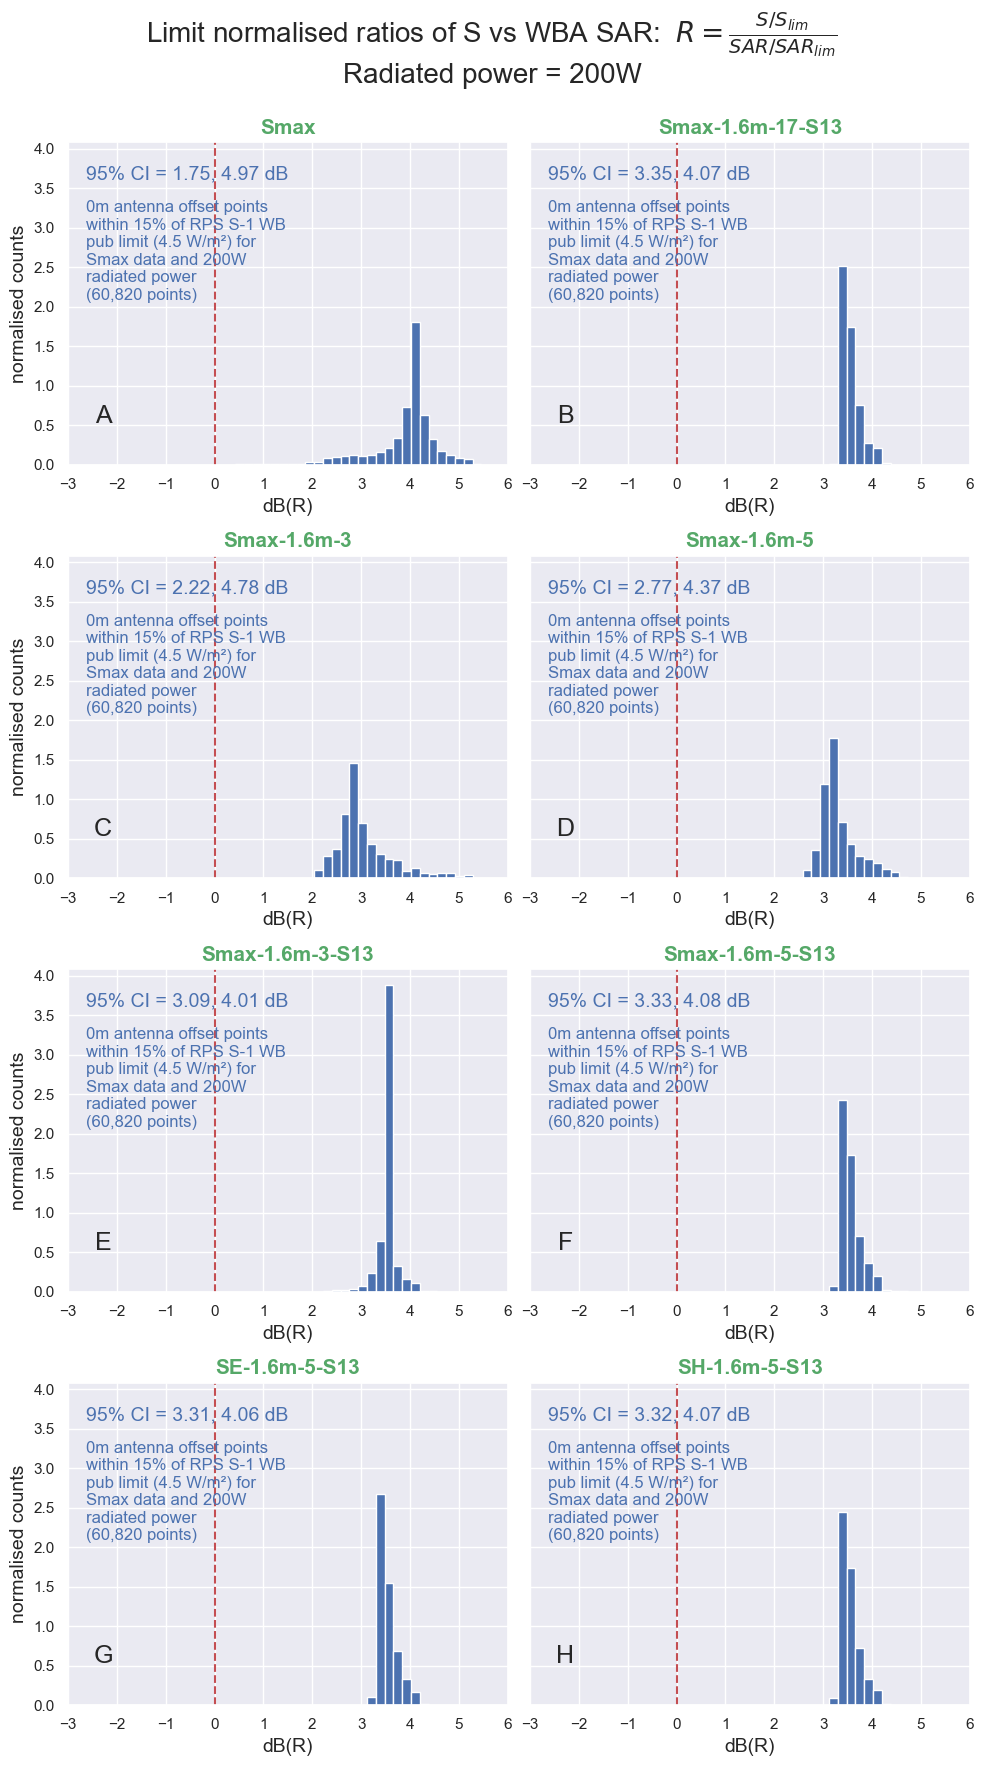

In [34]:
power = 200
f = R.sf('cb', setting='pub', data='Smax', offset=0,
           errtol=0.15, spatavgL=1.6, power=power, standard='RPS S-1 WB')
sflist_c = [['Smax',f],
            ['Smax-1.6m-17-S13',f],
            ['Smax-1.6m-3',f],
            ['Smax-1.6m-5',f],
            ['Smax-1.6m-3-S13',f],
            ['Smax-1.6m-5-S13',f],
            ['SE-1.6m-5-S13',f],
            ['SH-1.6m-5-S13',f]]

histR(sflist_c,dB=True,cols=2,power=power)
plotfile = f'R histogram panel cb {power}W.png'
plt.savefig(plotdir + plotfile, dpi=150)
plotfile

#### R histograms for valid 1.6m points at cb and 50W <= P <= 200W

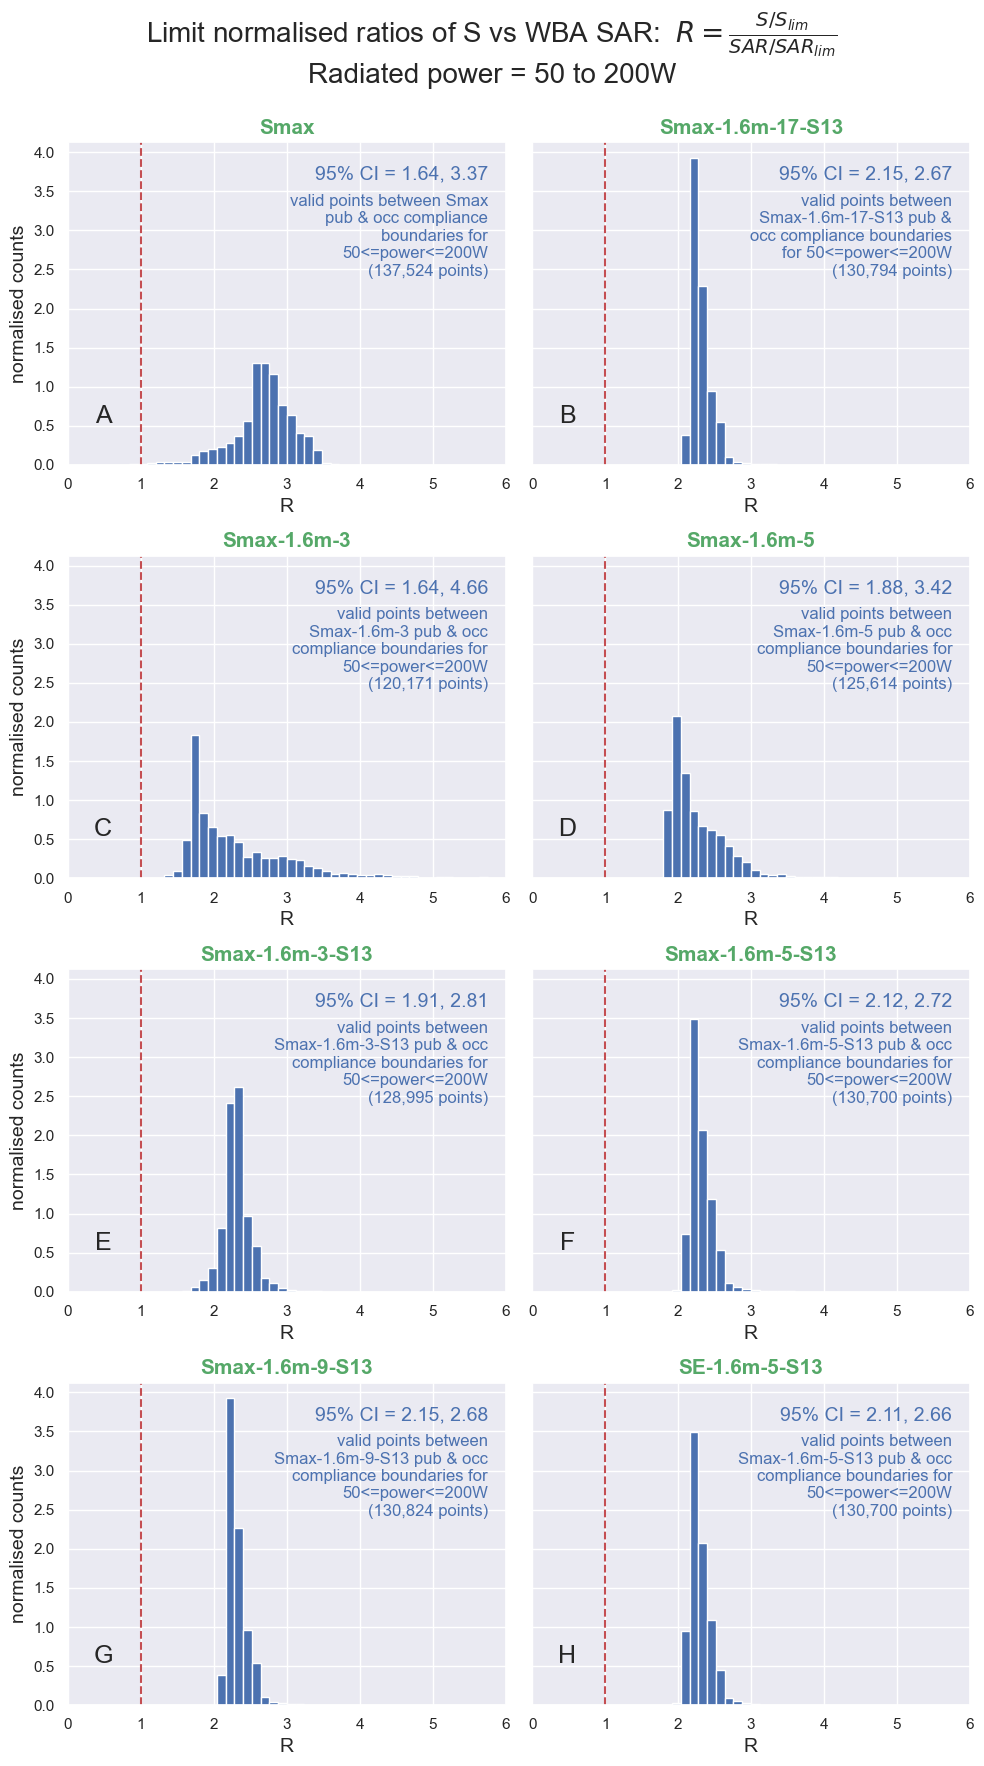

In [30]:
sflist = [['Smax',f_Smax_cb50to200W],
          ['Smax-1.6m-17-S13',f_Smax_cb50to200W_sa16_17_S13],
          ['Smax-1.6m-3',f_Smax_cb50to200W_sa16_3],
          ['Smax-1.6m-5',f_Smax_cb50to200W_sa16_5],
          ['Smax-1.6m-3-S13',f_Smax_cb50to200W_sa16_3_S13],
          ['Smax-1.6m-5-S13',f_Smax_cb50to200W_sa16_5_S13],
          ['Smax-1.6m-9-S13',f_Smax_cb50to200W_sa16_9_S13],
          ['SE-1.6m-5-S13',f_Smax_cb50to200W_sa16_5_S13]]

histR(sflist,dB=False,cols=2,power='50 to 200')
plt.savefig(plotdir + 'R histogram panel 50 to 200W.png', dpi=150)

In [36]:
showstats(sflist,dB=False)

Si   count  mean   std   min  2.5%   50%  97.5%     max
panel                                                                       
A                  Smax  137524  2.67  0.43  0.34  1.64  2.70   3.37    6.98
B      Smax-1.6m-17-S13  130794  2.33  0.36  1.95  2.15  2.27   2.67   41.77
C           Smax-1.6m-3  120171  2.41  1.35  1.31  1.64  2.10   4.66  132.14
D           Smax-1.6m-5  125614  2.31  0.89  1.52  1.88  2.15   3.42  123.27
E       Smax-1.6m-3-S13  128995  2.33  0.64  1.54  1.91  2.29   2.81  102.50
F       Smax-1.6m-5-S13  130700  2.33  0.37  1.70  2.12  2.28   2.72   51.77
G       Smax-1.6m-9-S13  130824  2.33  0.35  1.92  2.15  2.27   2.68   42.44
H         SE-1.6m-5-S13  130700  2.31  0.34  1.66  2.11  2.26   2.66   38.75

### R vs r

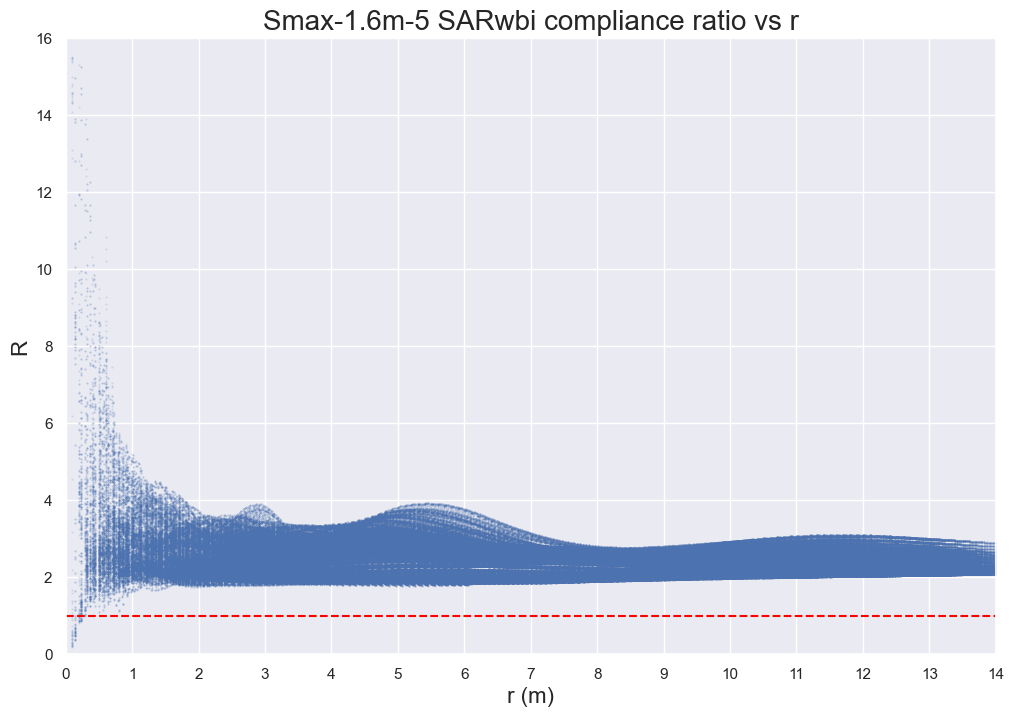

In [57]:
Ssa = 'R Smax-1.6m-5'
mask = f_sa16.mask
ydata = R.S.loc[mask,Ssa]
title = f'{R.datatitles[Ssa]} vs r'
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r'], y=ydata,alpha=0.2,s=0.2);
ax.set_title(title,fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.set_xlim((0,14))
ax.set_ylim((0,16))
ax.set_xticks(range(15))
ax.hlines(1,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'R vs r scatter ({Ssa}) valid 1.6m points panel.png')

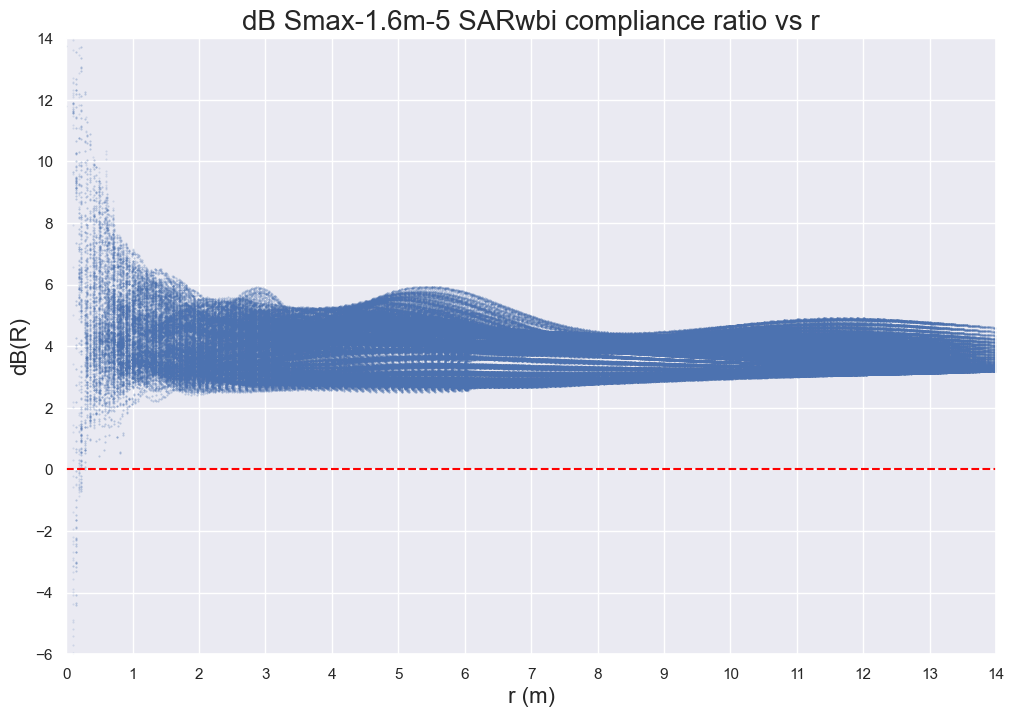

In [56]:
# dB(R) vs r
Ssa = 'R Smax-1.6m-5'
mask = f_sa16.mask
ydata = 10. * np.log10(R.S.loc[mask,Ssa])
title = f'dB {R.datatitles[Ssa]} vs r'
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r'], y=ydata,alpha=0.2,s=0.2);
ax.set_title(title,fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('dB(R)', fontsize=16)
ax.set_xlim((0,14))
ax.set_ylim((-6,14))
ax.set_xticks(range(15))
ax.set_yticks(range(-6,15,2))
ax.hlines(0,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'dB(R) vs r scatter ({Ssa}).png')

## Point spatial vs spatial average uncertainty

### Compare compliance zones for SE vs Smax-1.6m-17-S13

In [178]:
# Compare SE and SE-1.6m-5
n = 2
R.ExclusionZone(
    data=["SE","SE-1.6m-17-S13"],
    power=[40] * n,
    color=["lightgrey","green"],
    alpha=[0.7, 0.4],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="SE vs SE-1.6m-5 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.panelAntenna,
)

dat='SE', con=22.5
dat='SE-1.6m-17-S13', con=22.5
[0.0, 4.3, -1.4, 1.4, -1.5, 1.5]
power=200, plotpower=40, setting=public, limit=4.5 W/m², contour level=22.500
power=200, plotpower=40, setting=public, limit=4.5 W/m², contour level=22.500


### Create error data column in R.S

In [32]:
# Create error data
Silist = [['SE', 'Smax-1.6m-17-S13'],
          ['SE-1.6m-3', 'Smax-1.6m-17-S13'],
          ['SE-1.6m-5', 'Smax-1.6m-17-S13'],
          ['SE-1.6m-3-S13', 'Smax-1.6m-17-S13'],
          ['SE-1.6m-5-S13', 'Smax-1.6m-17-S13'],
          ['SE-1.6m-9-S13', 'Smax-1.6m-17-S13'],
         ]
          
for (Si1, Si2) in Silist:
    err = R.S[Si1] / R.S[Si2]
    dBerr = 10. * np.log10(err)
    name = f'dBerr {Si1} v {Si2}'
    title = f'dB error for {Si1} / {Si2}'
    R.addS(dBerr, name, title)

### showstats_dBerr function

In [33]:
def showstats_dBerr(Silist, f):
    table = []
    for i, (Si1,Si2) in enumerate(Silist):
        Rcol = f'dBerr {Si1} v {Si2}'
        data = R.S.loc[f.mask,Rcol]
        data = data.dropna()  # remove any nan values
        dataname = ''
        panel = LETTERS[i]
        count = len(data)
        ci = np.percentile(data,[2.5,50,97.5]).round(2)
        mean = data.mean().round(2)
        std = data.std().round(2)
        minval = data.min().round(2)
        maxval = data.max().round(2)
        table.append([panel,Si1,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    df = pd.DataFrame(table,columns=('panel','Si','count','mean','std','min','2.5%','50%','97.5%','max'))
    df.columns.name = dataname
    
    return df.set_index('panel')

### Analyse all valid points

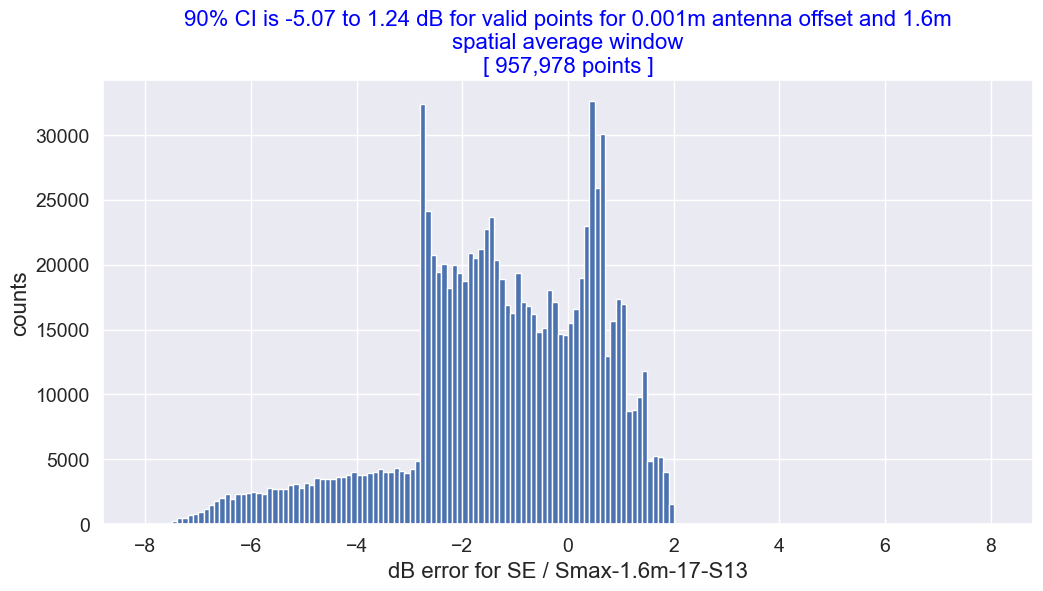

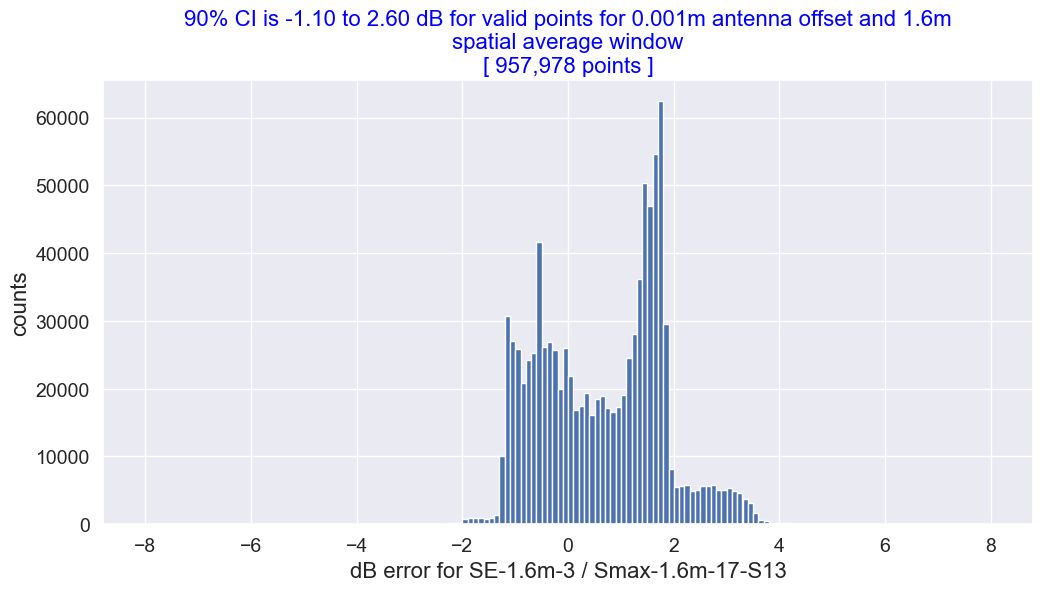

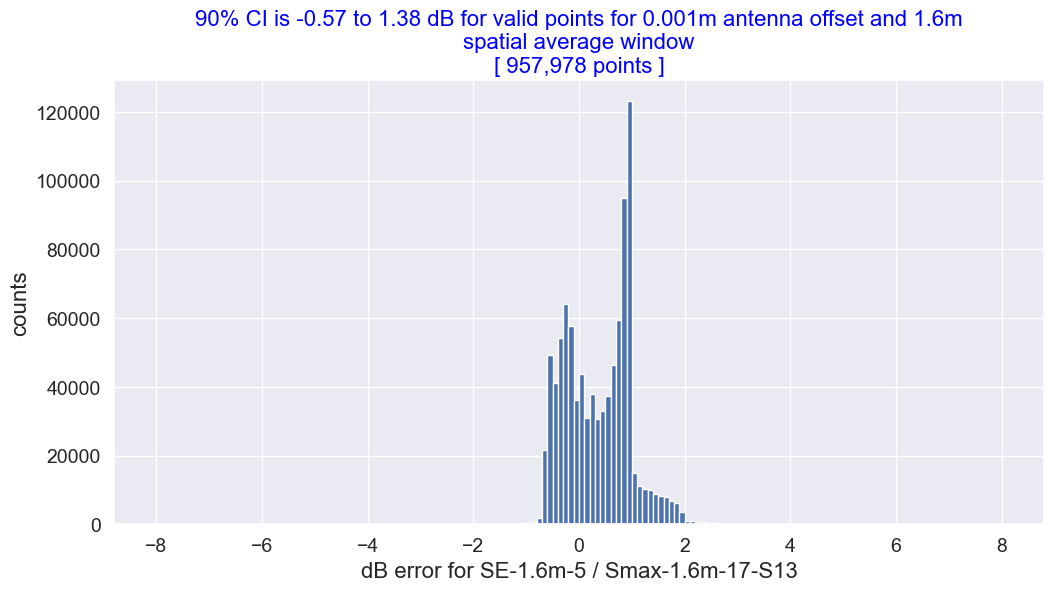

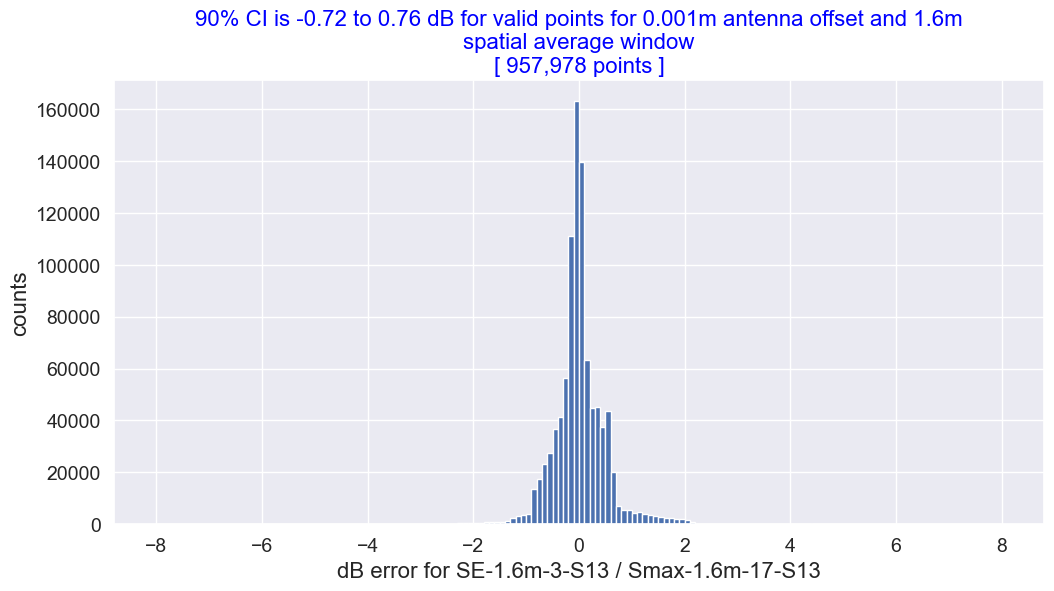

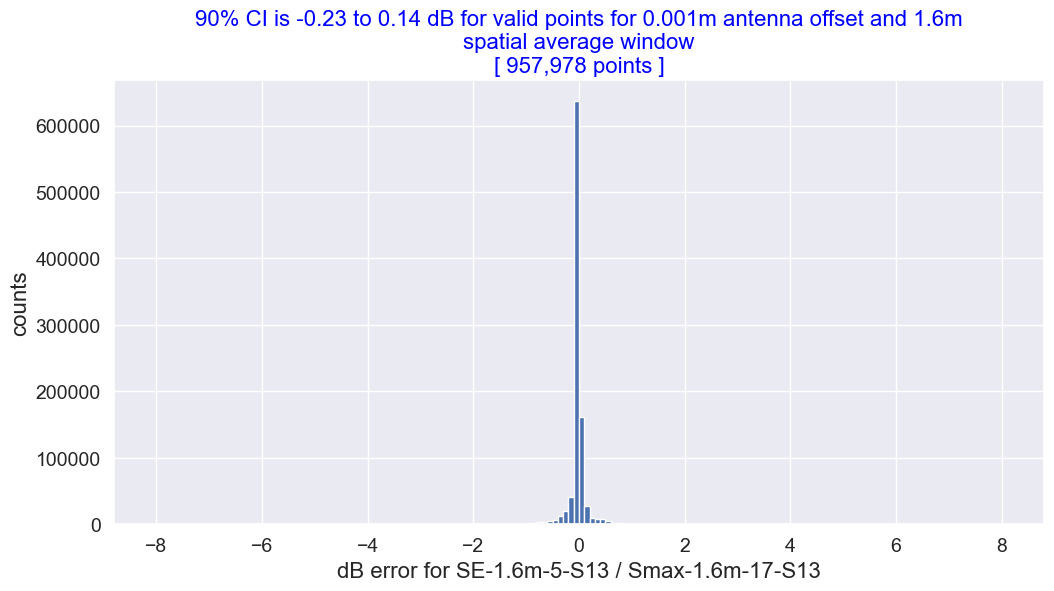

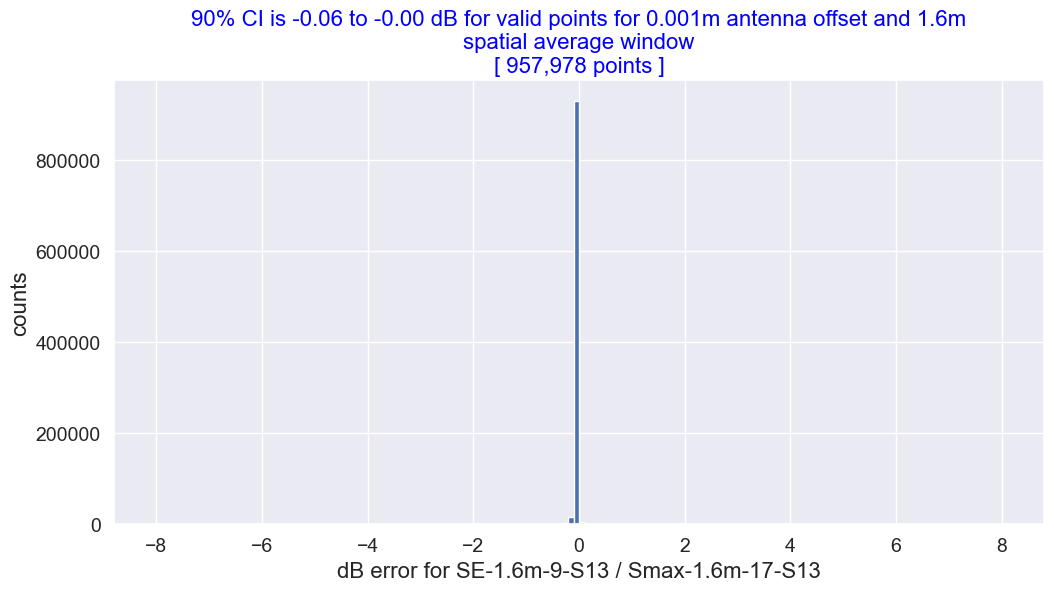

In [34]:
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=f_sa16, CI=90, bins=np.arange(-8,8.1,0.1))

### Analyse points close to the antenna (within λ)

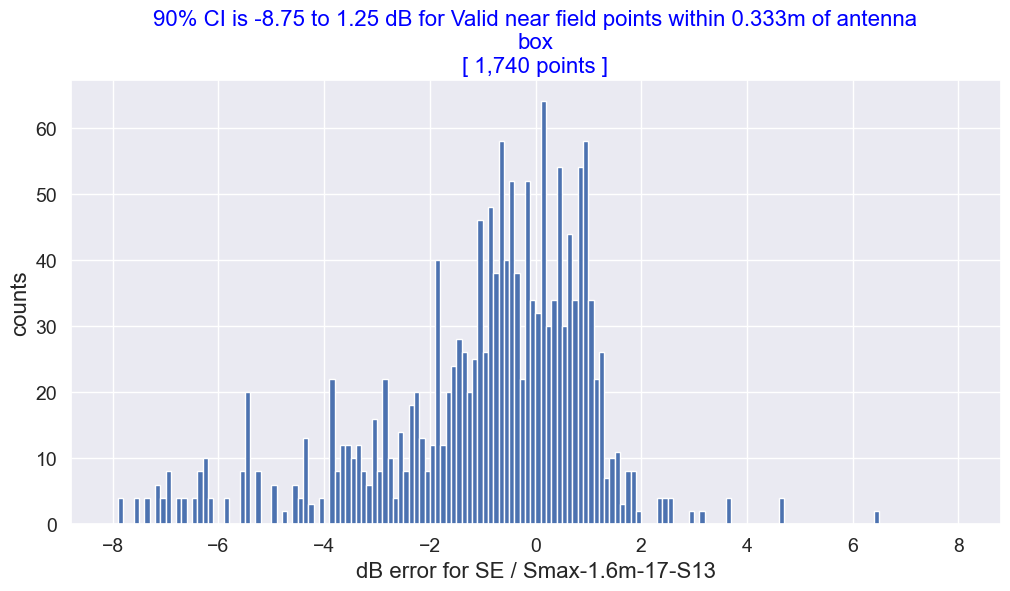

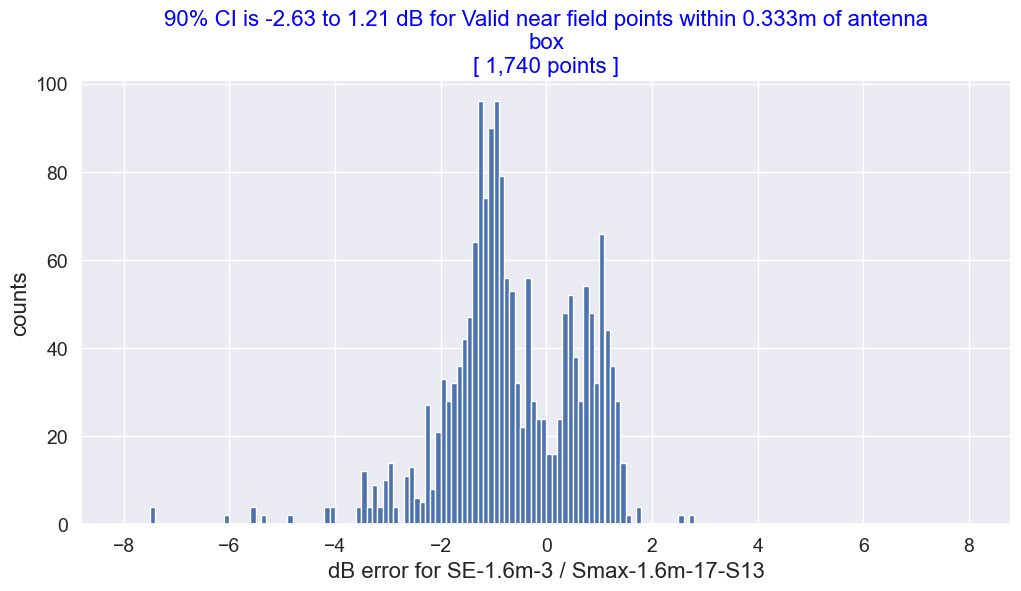

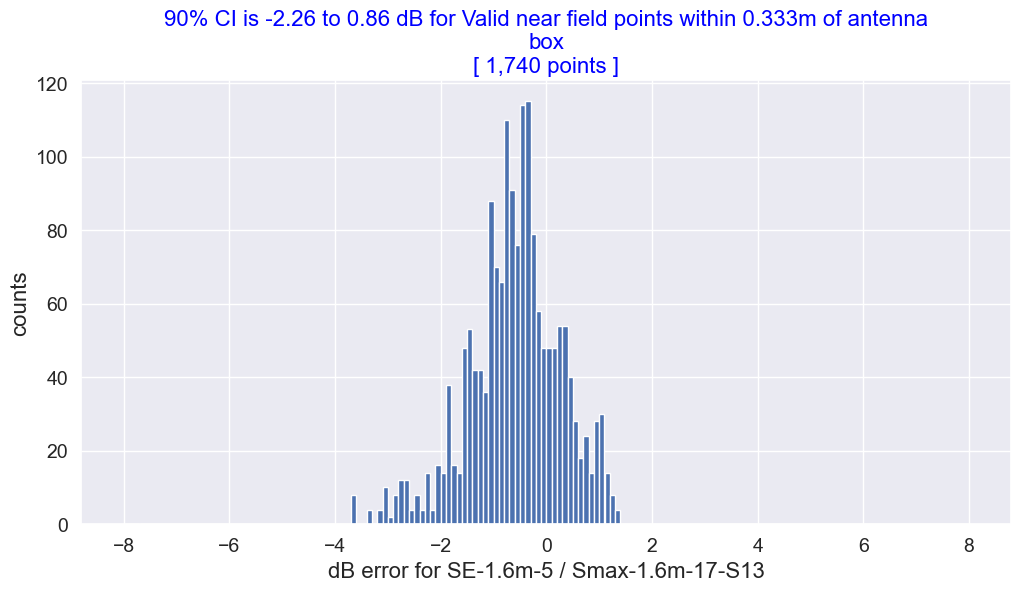

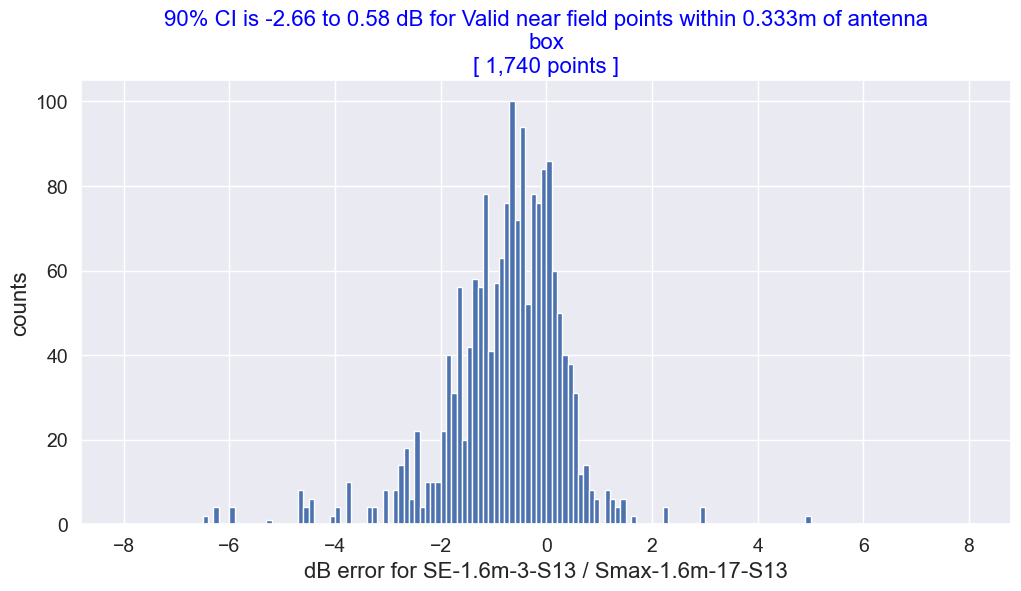

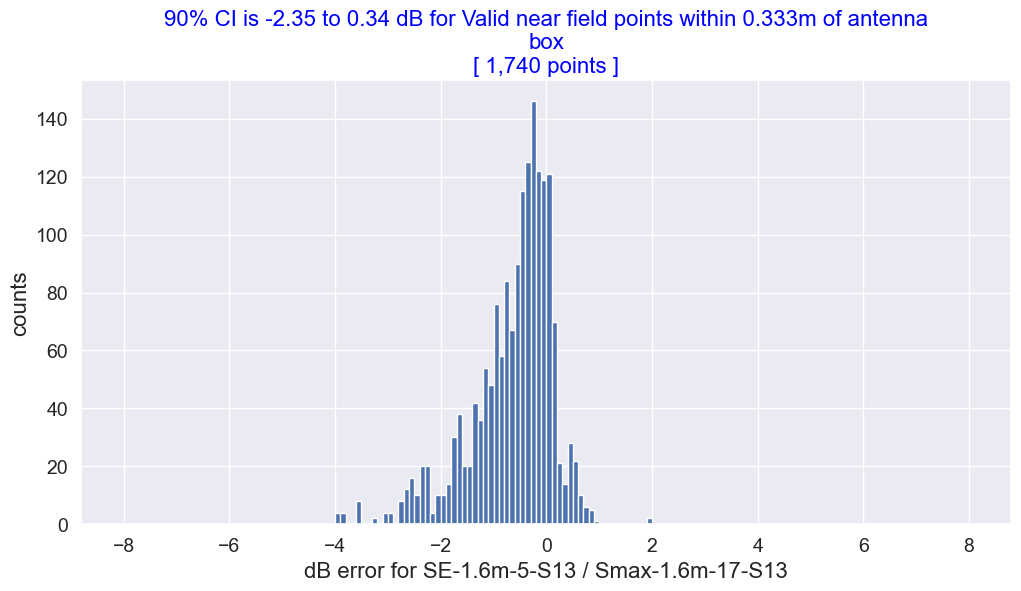

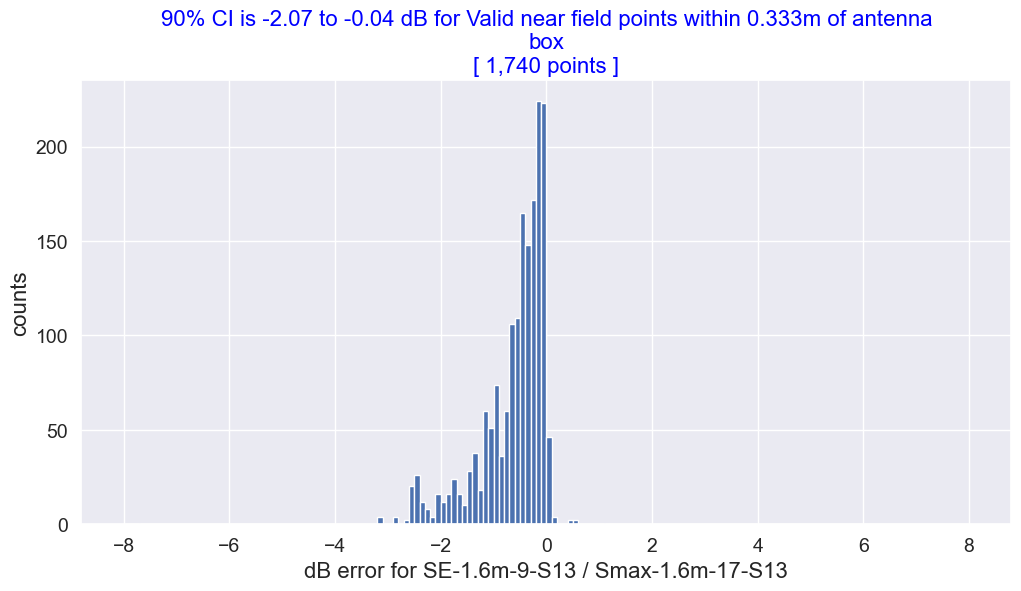

In [35]:
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=f_near_sa16, CI=90, bins=np.arange(-8,8.1,0.1))

### Analyse points *not* close to the antenna (further than λ)

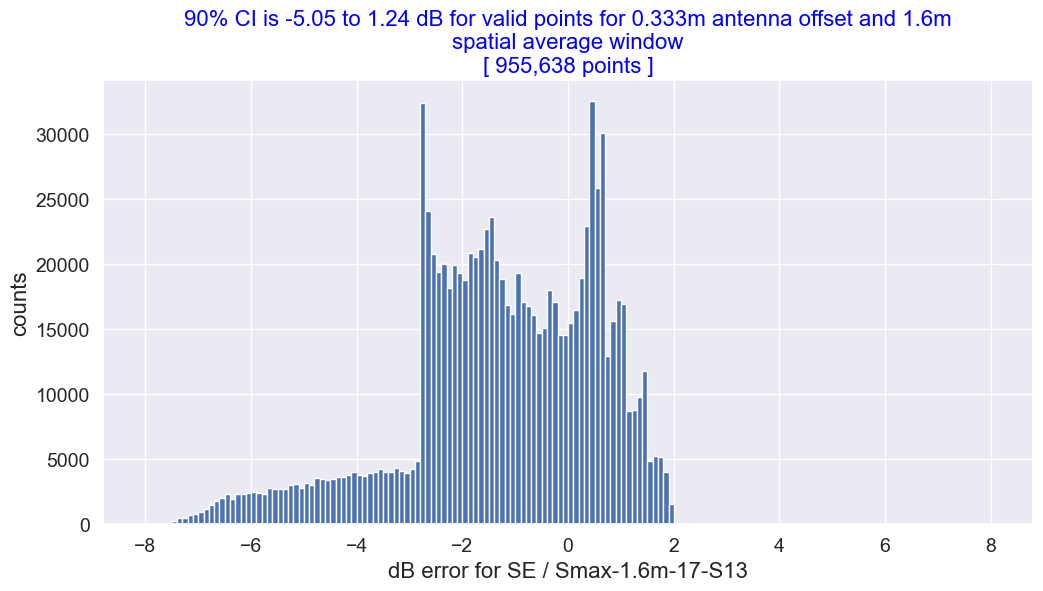

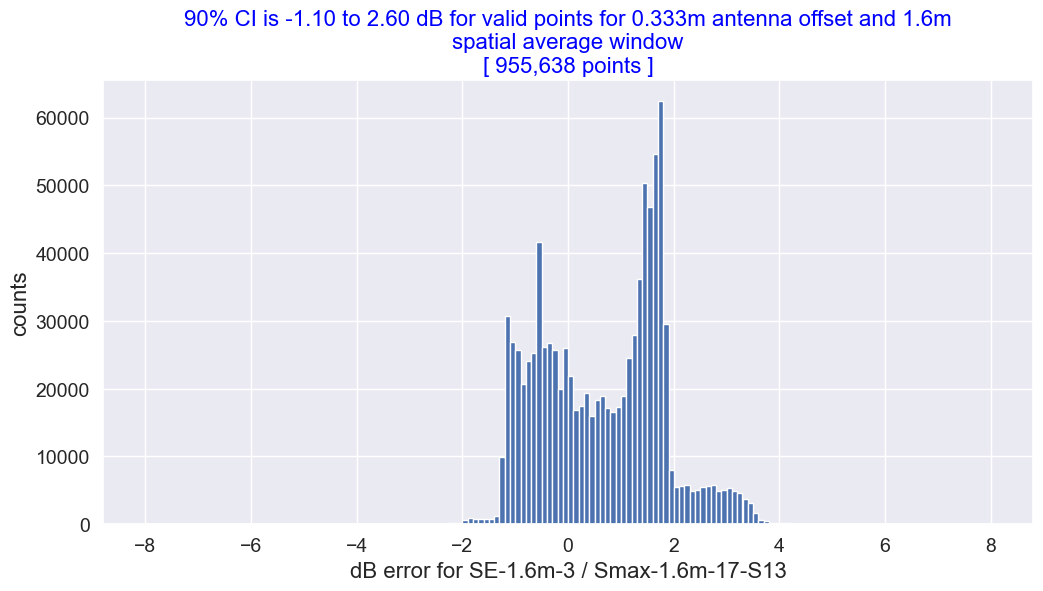

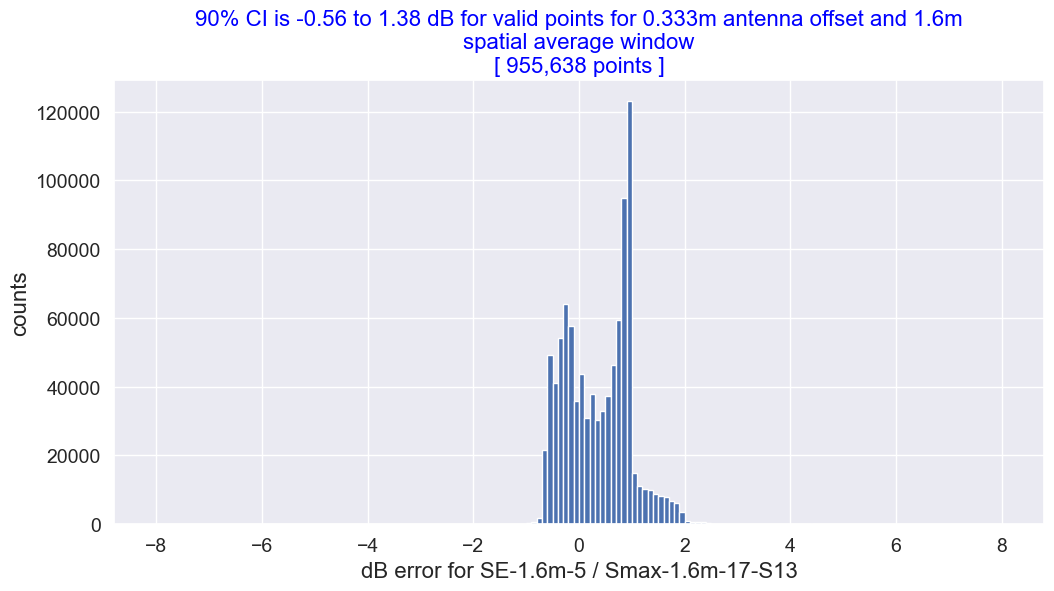

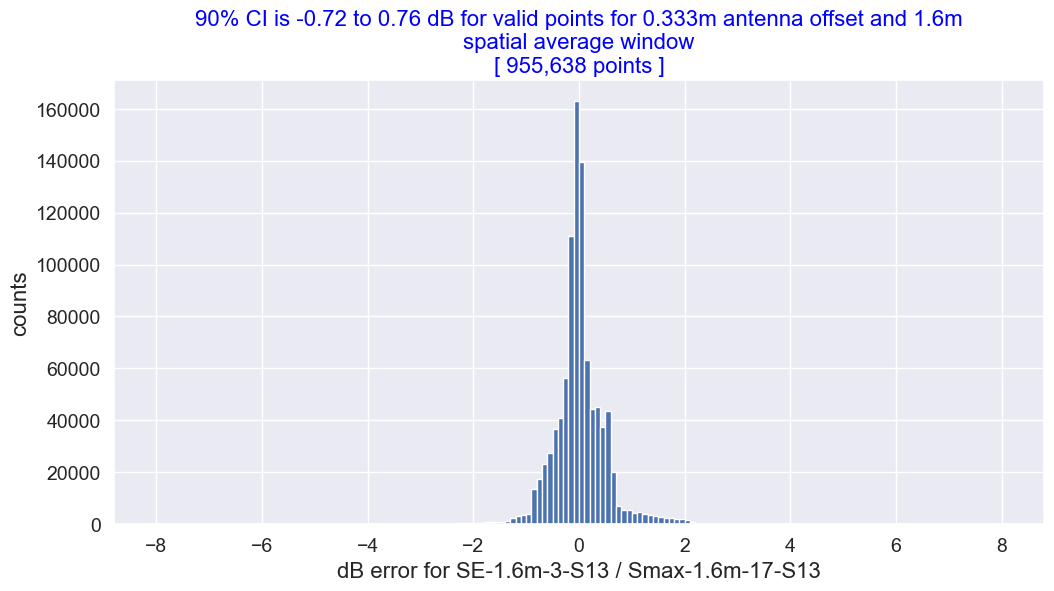

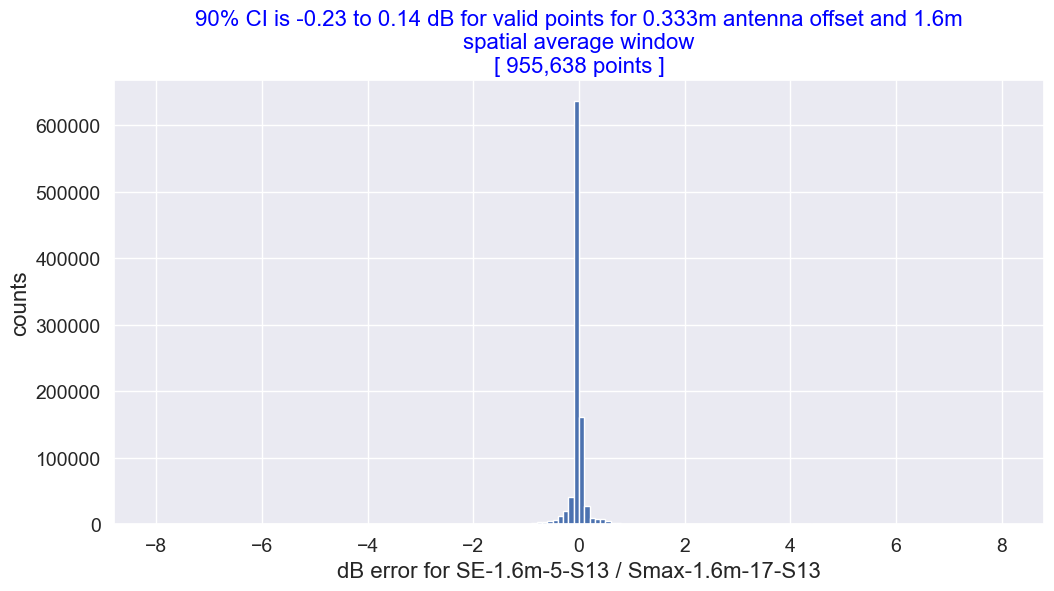

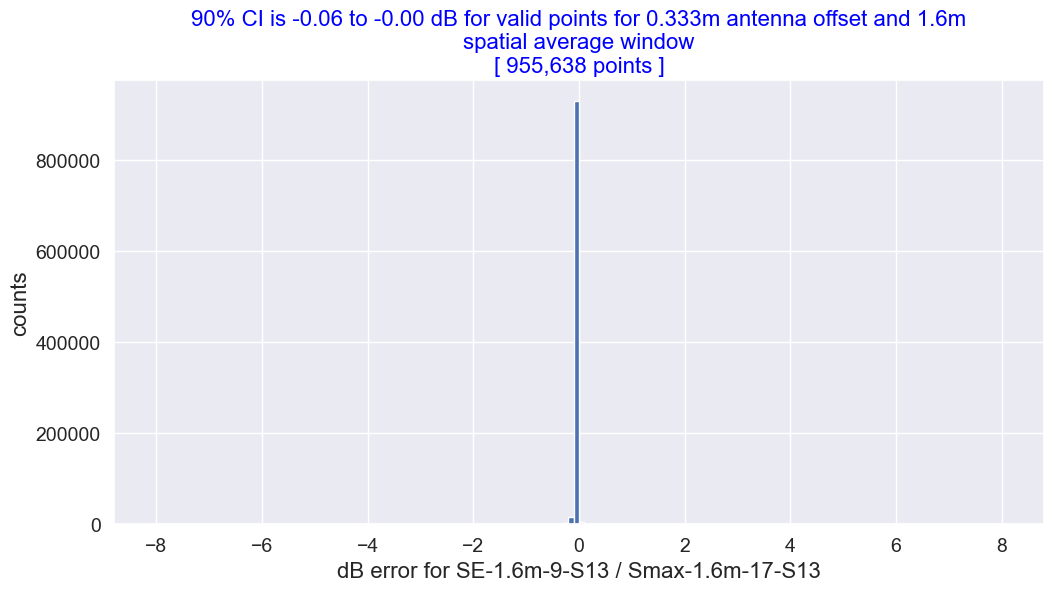

In [36]:
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=f_far_sa16, CI=90, bins=np.arange(-8,8.1,0.1))

### Analyse points near the public compliance boundary

#### Prad = 200W

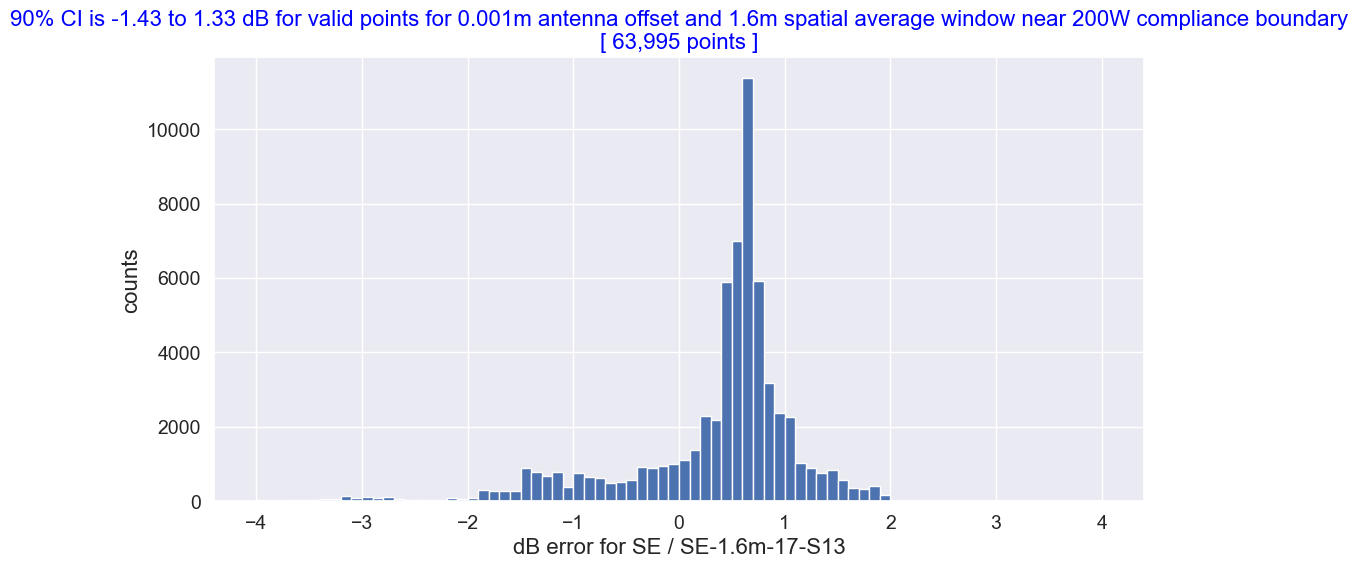

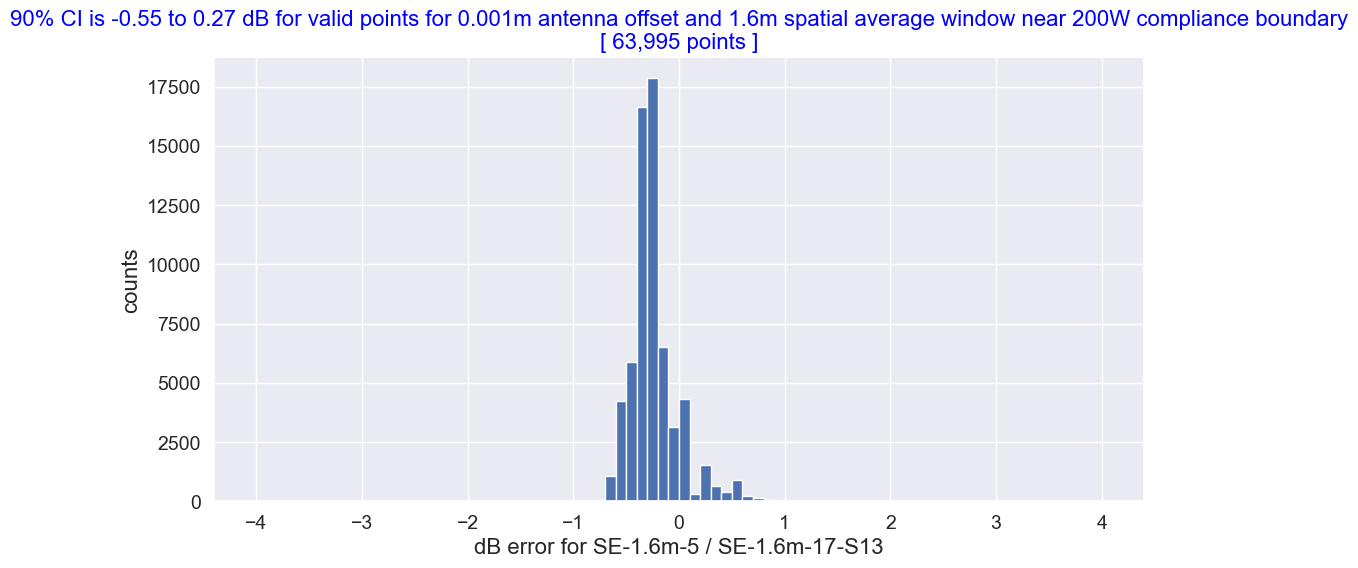

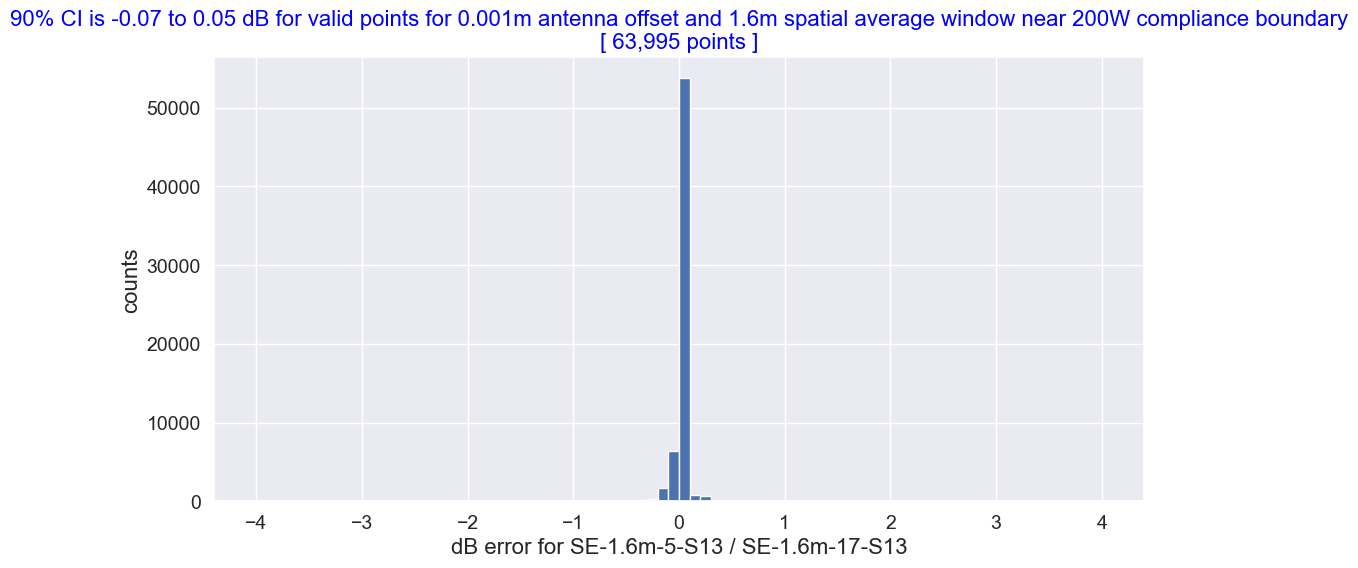

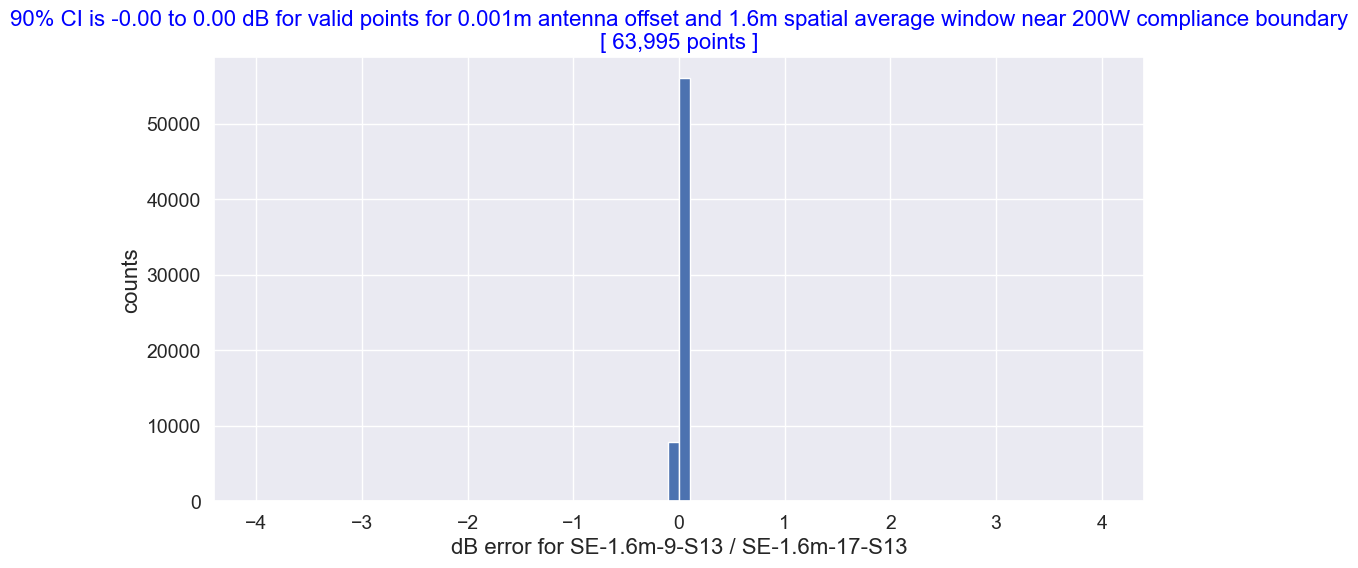

In [96]:
fcb = f_sa16_cb200W
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=fcb, CI=90, bins=np.arange(-4,4.1,0.1))

#### Prad = 150W

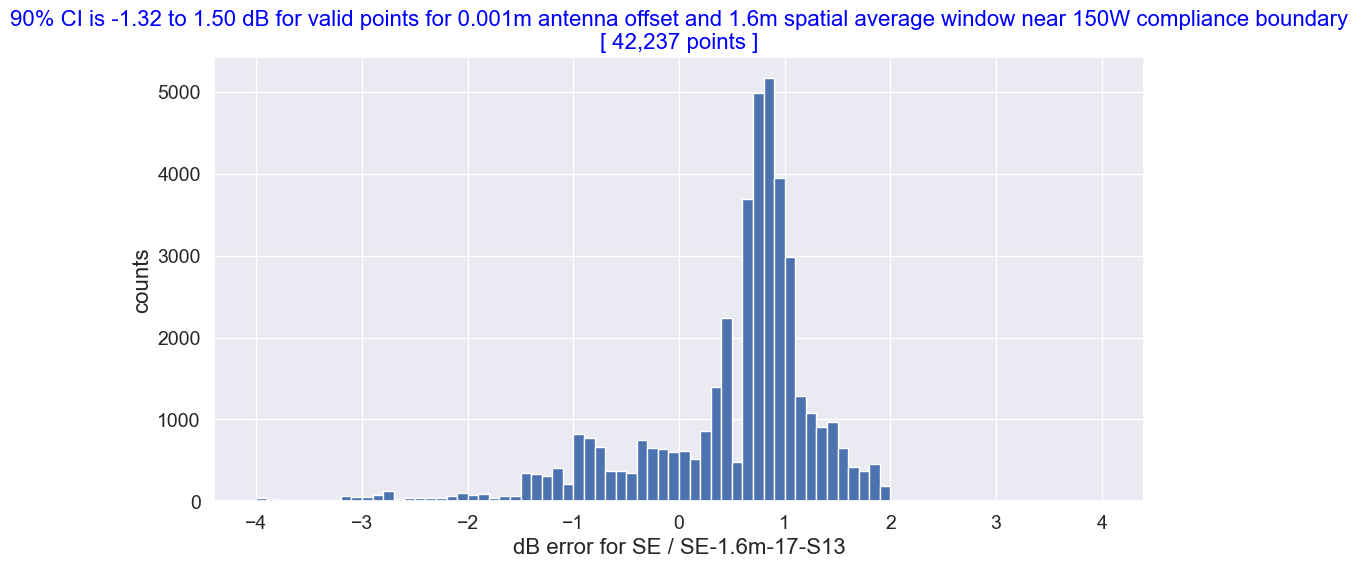

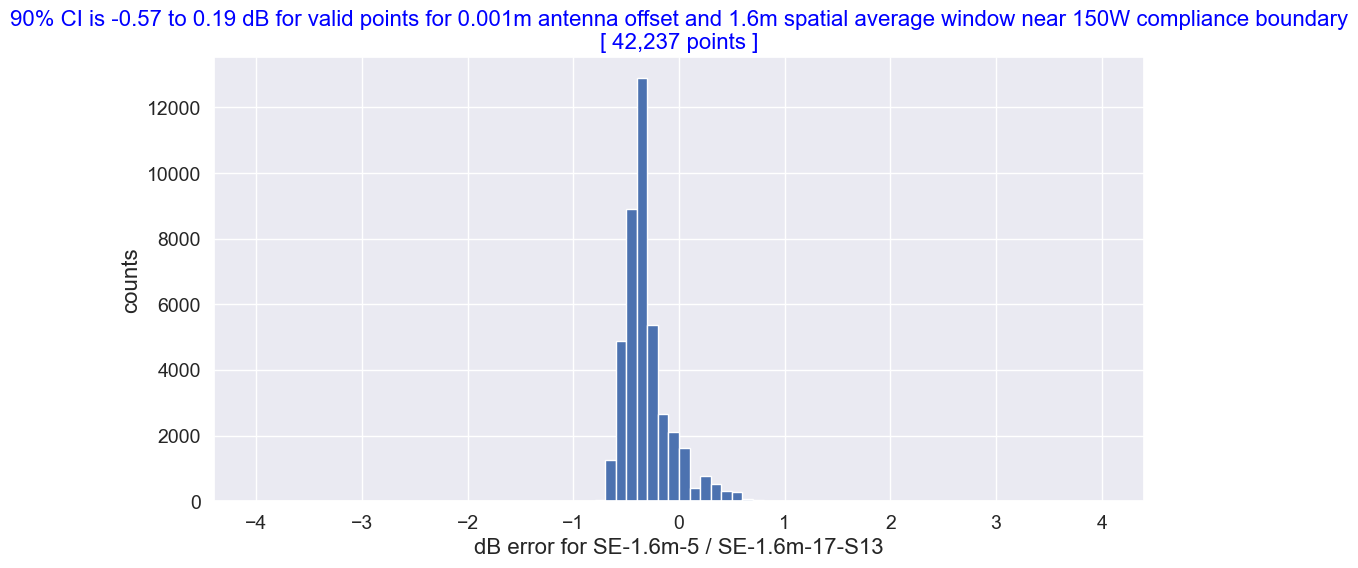

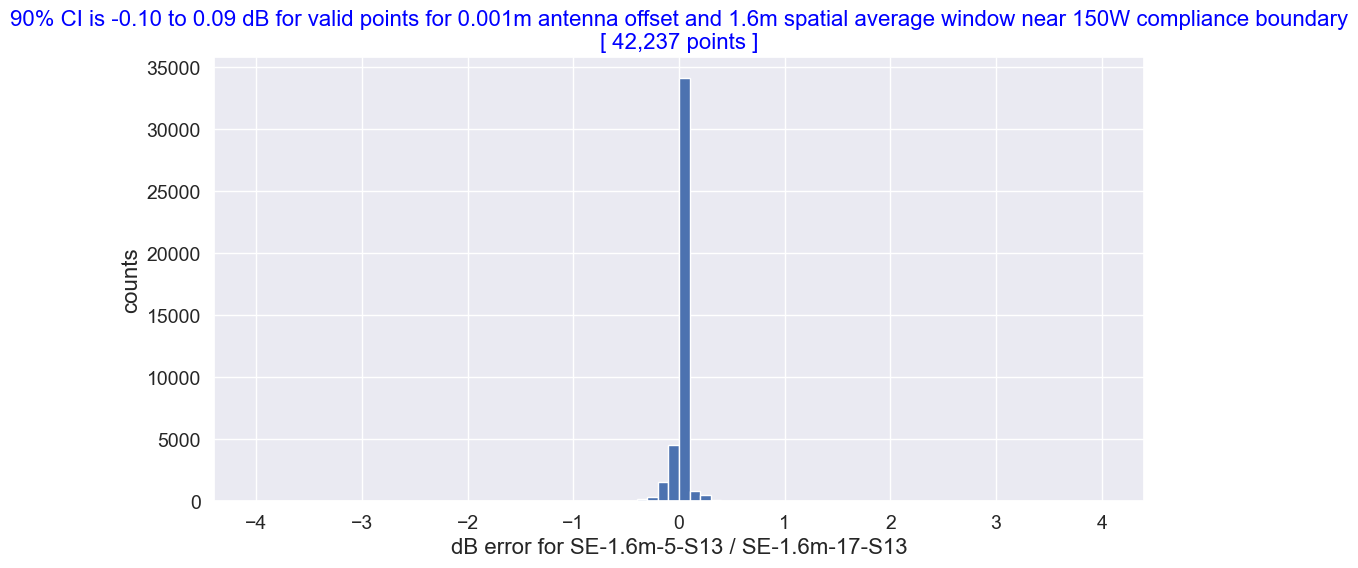

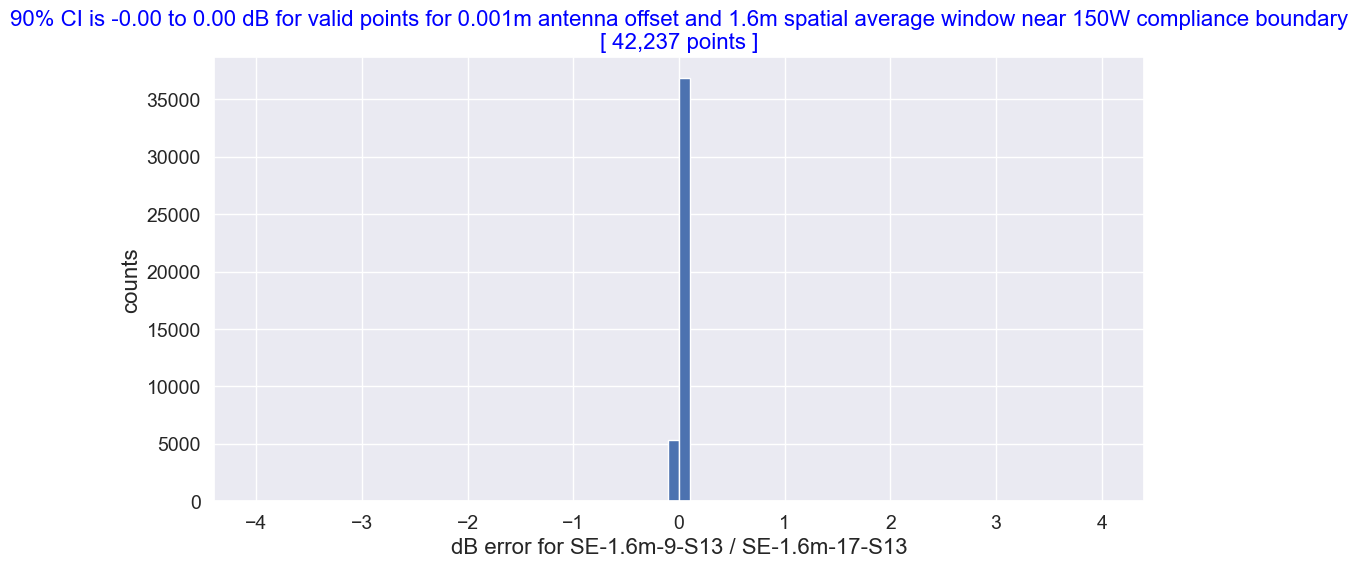

In [98]:
fcb = f_sa16_cb150W
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=fcb, CI=90, bins=np.arange(-4,4.1,0.1))

#### Prad = 100W

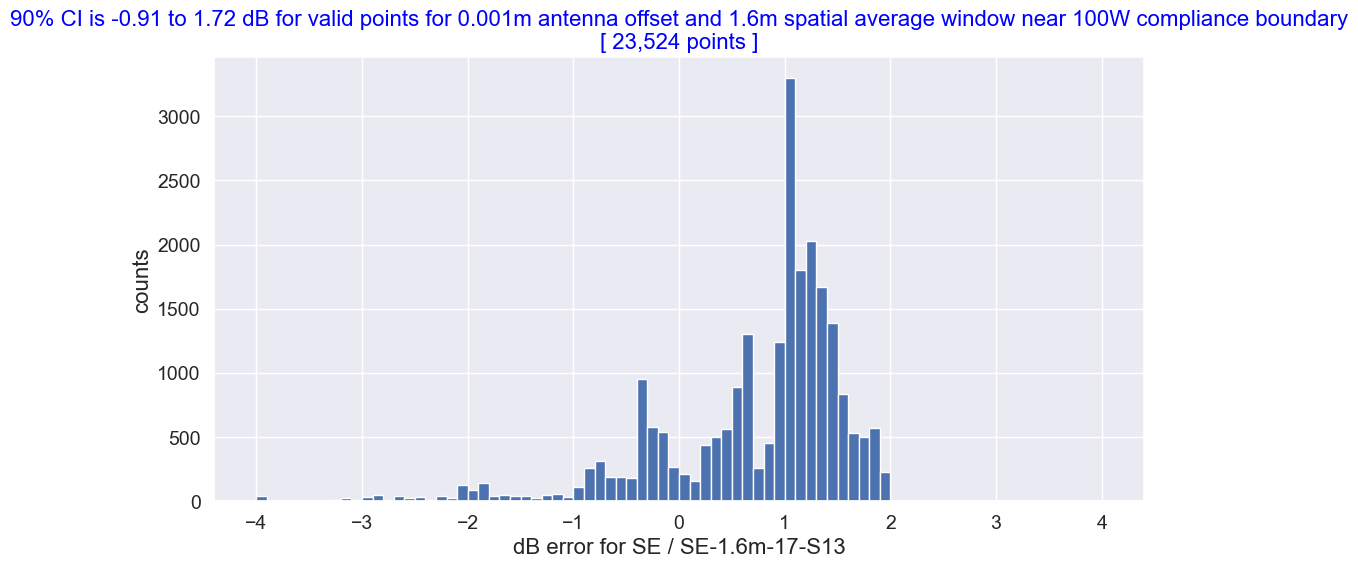

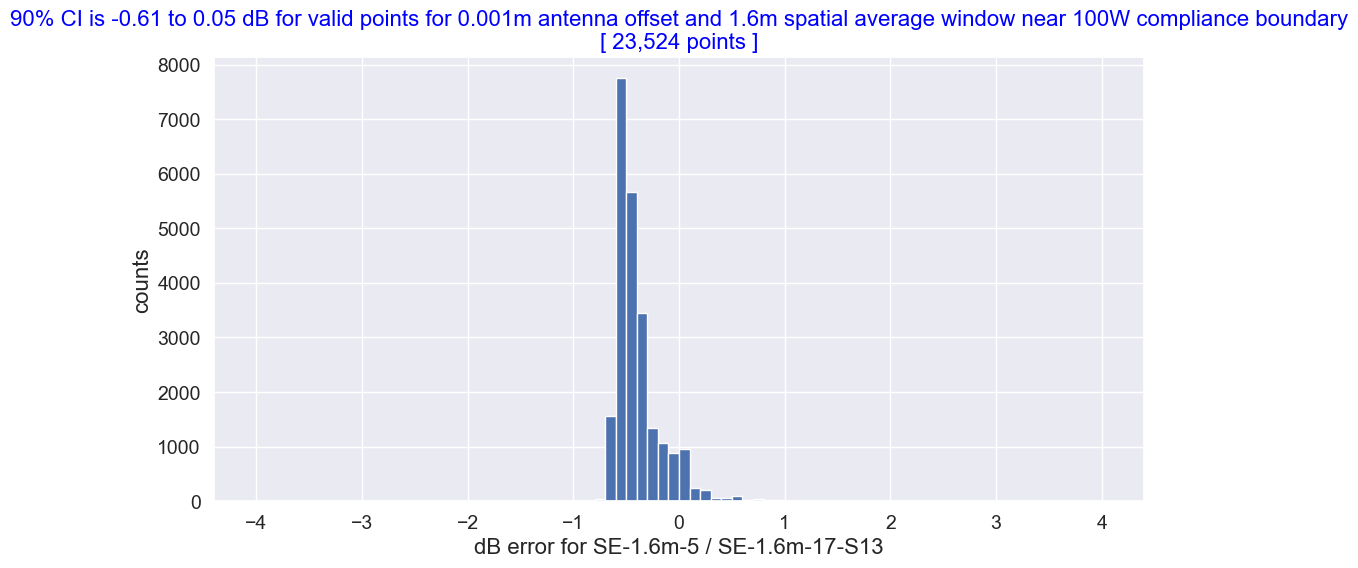

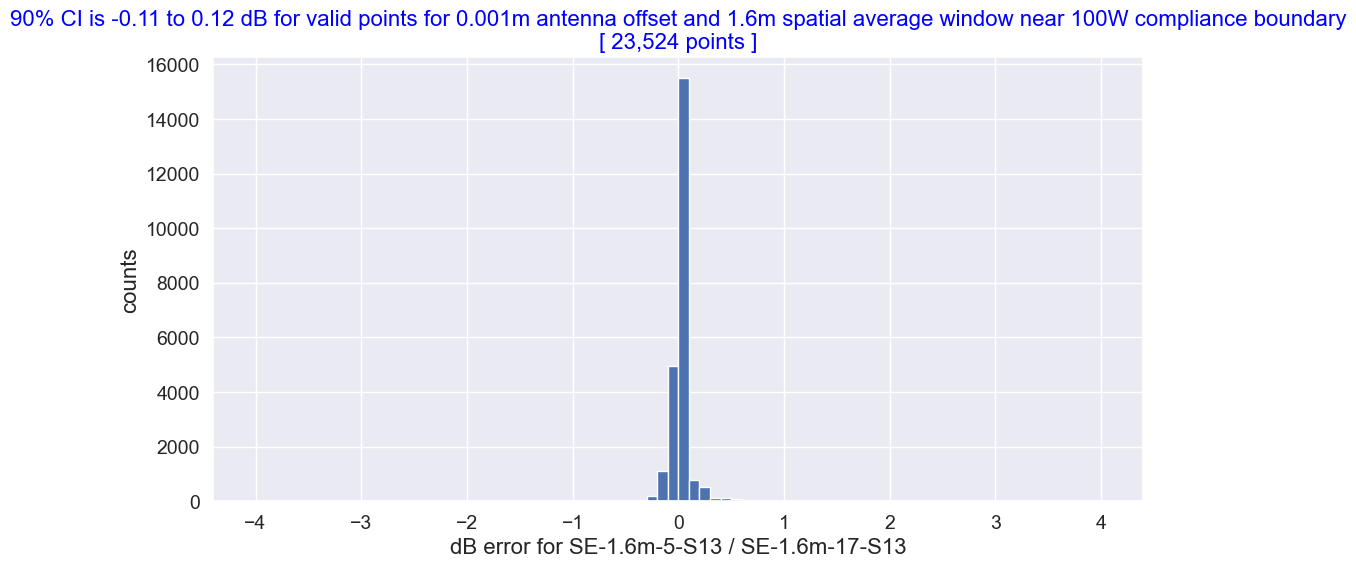

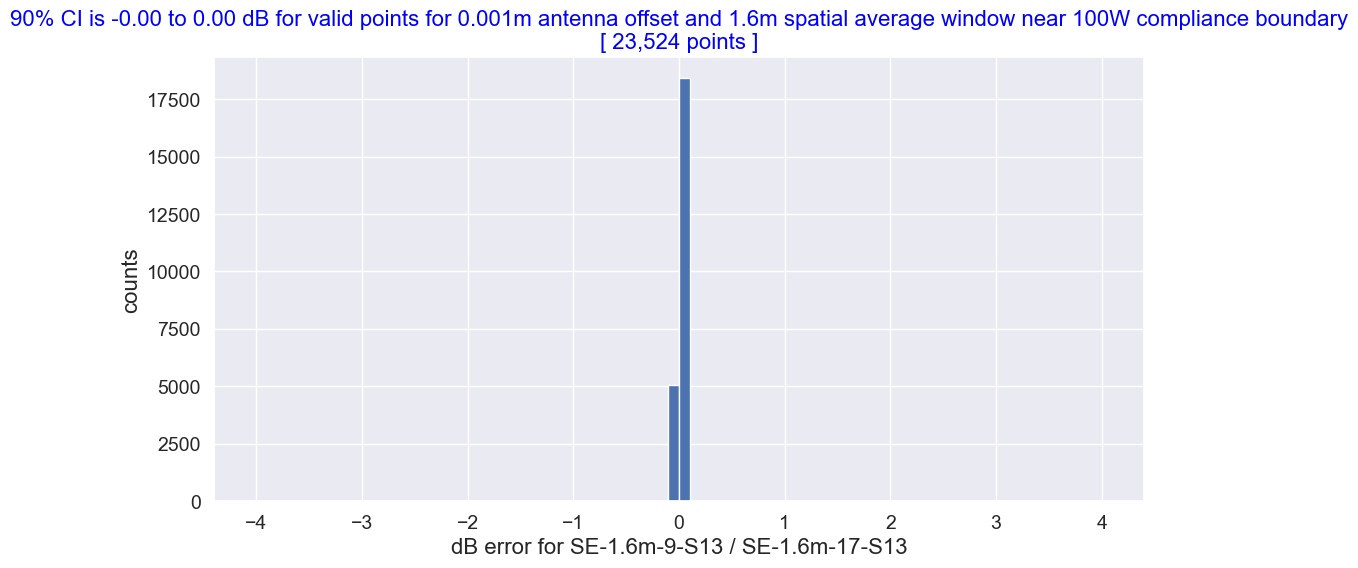

In [99]:
fcb = f_sa16_cb100W
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=fcb, CI=90, bins=np.arange(-4,4.1,0.1))

#### Prad = 50W

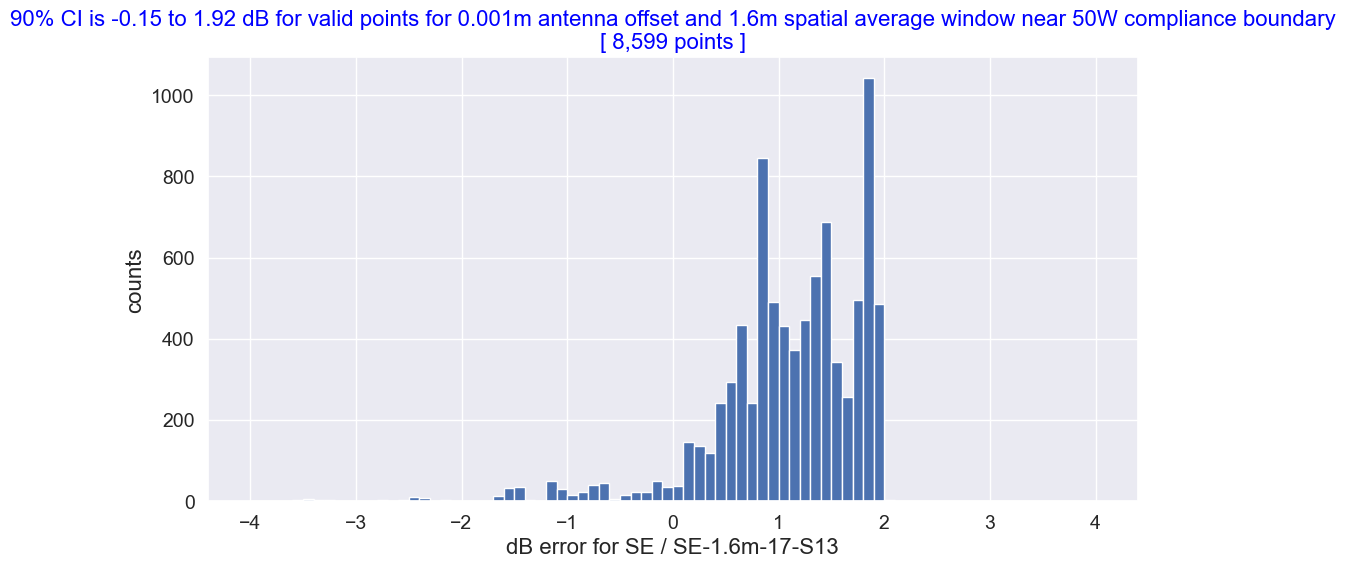

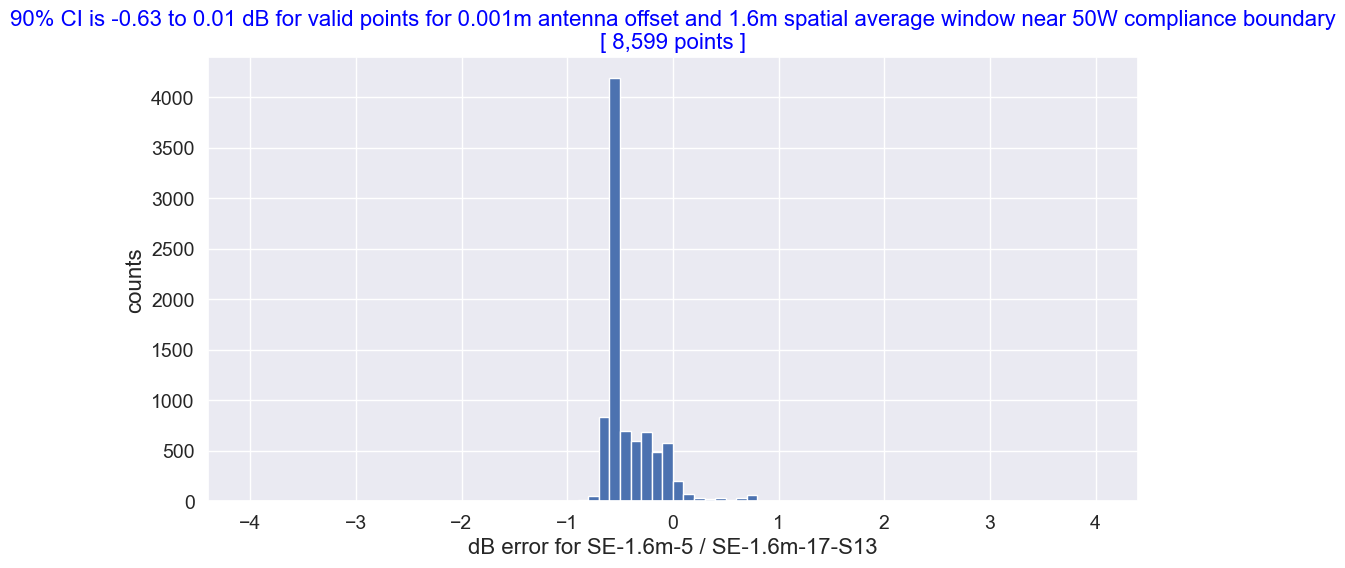

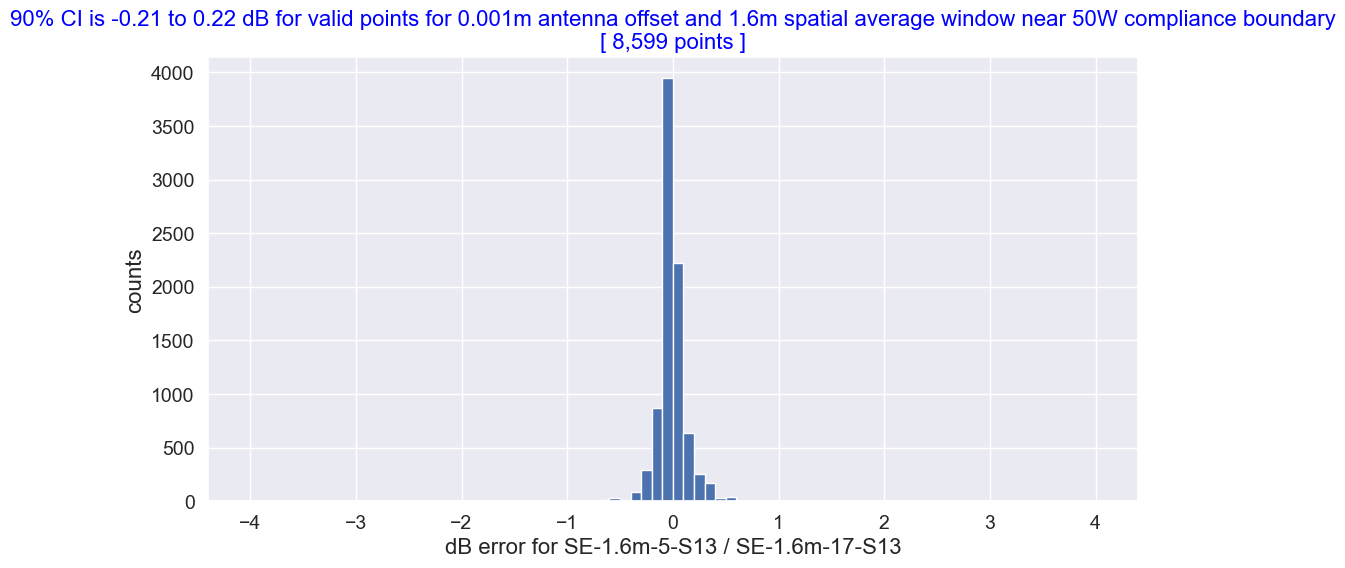

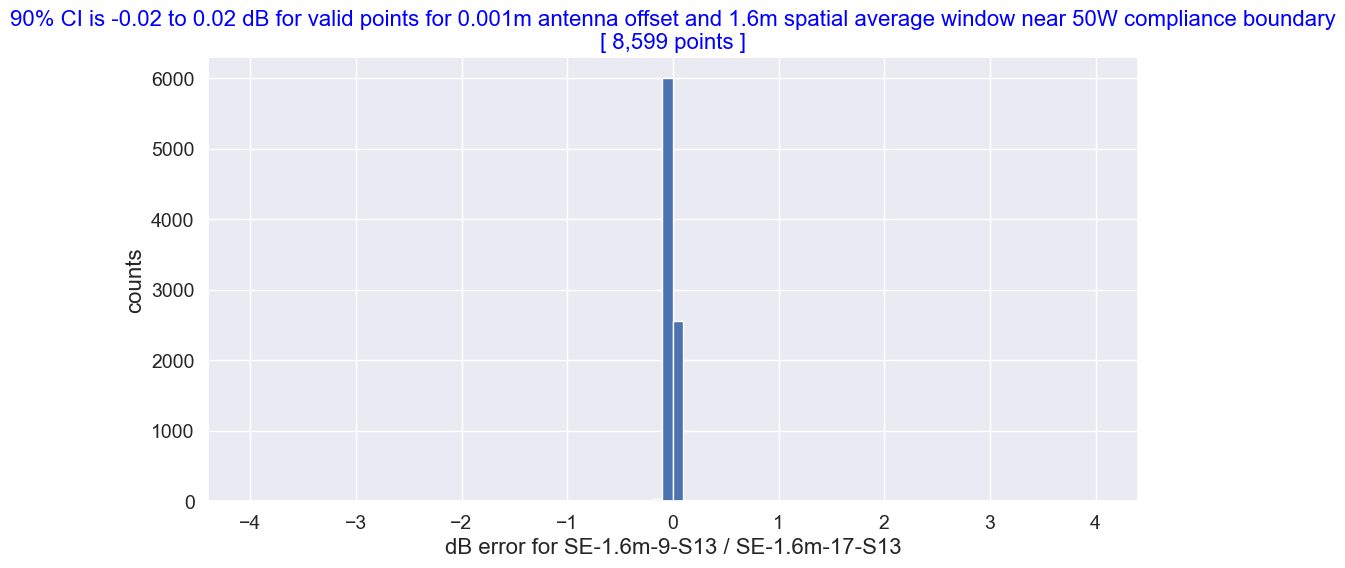

In [100]:
fcb = f_sa16_cb50W
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=fcb, CI=90, bins=np.arange(-4,4.1,0.1))

### Analyse points between 50W occ and 200W public compliance boundaries

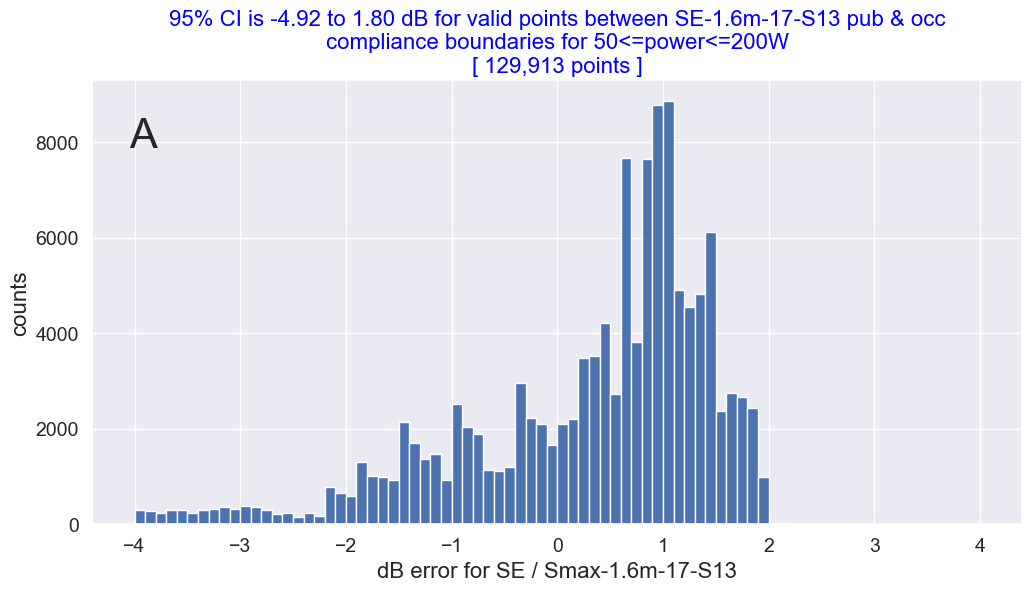

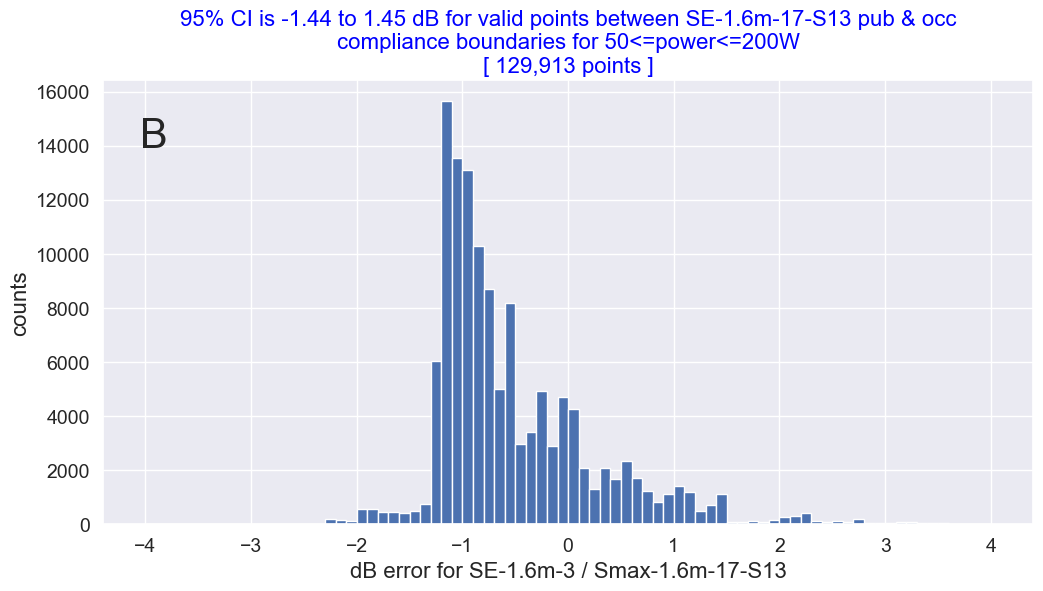

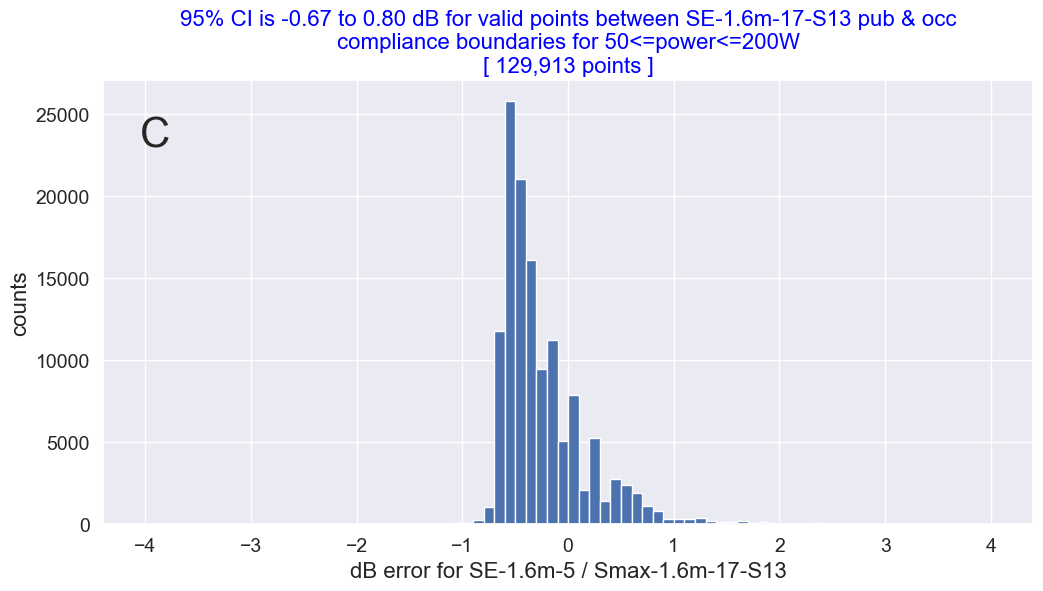

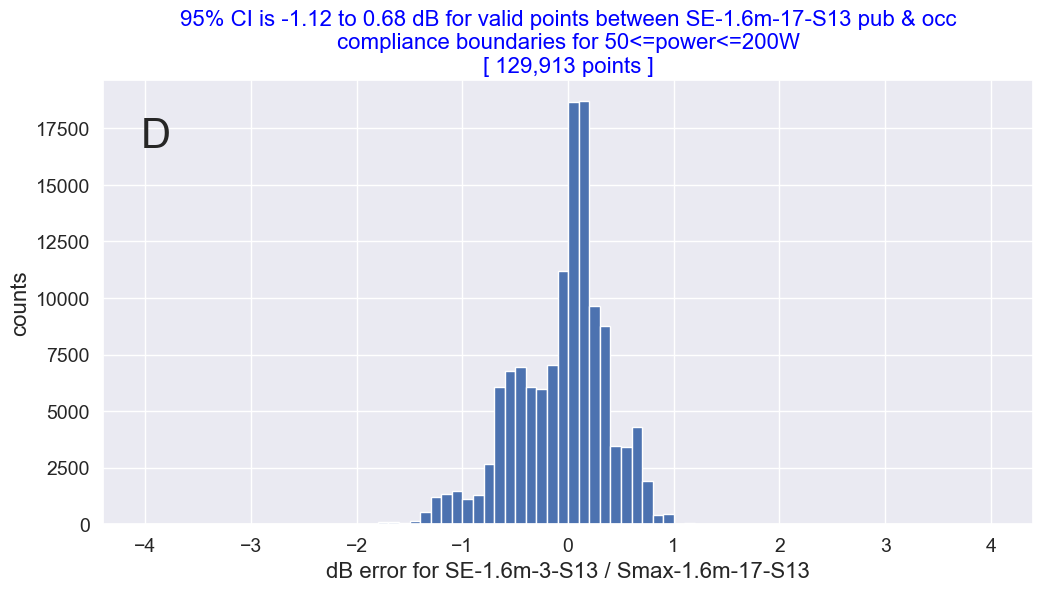

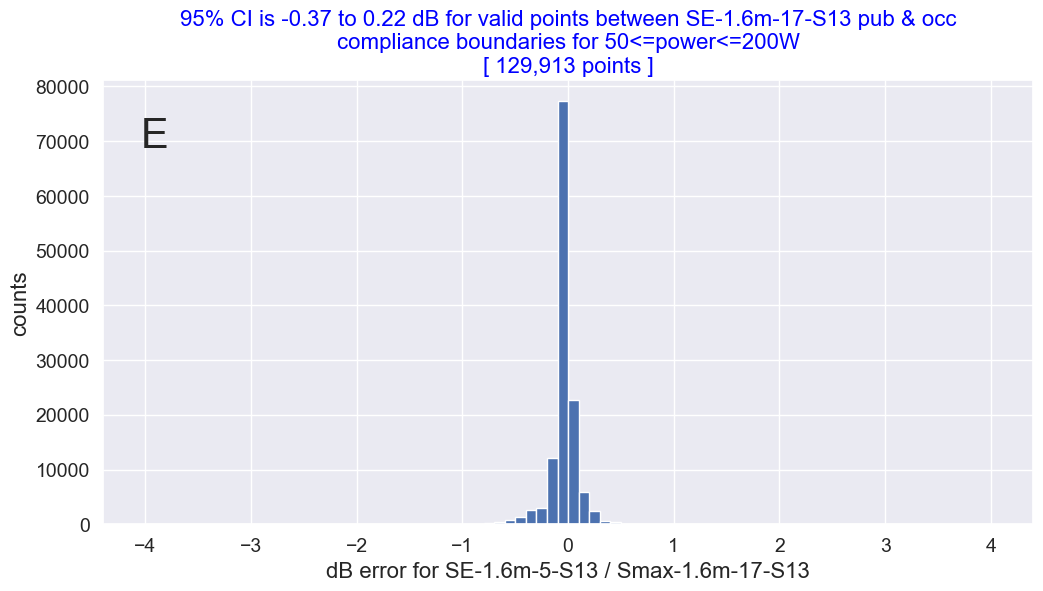

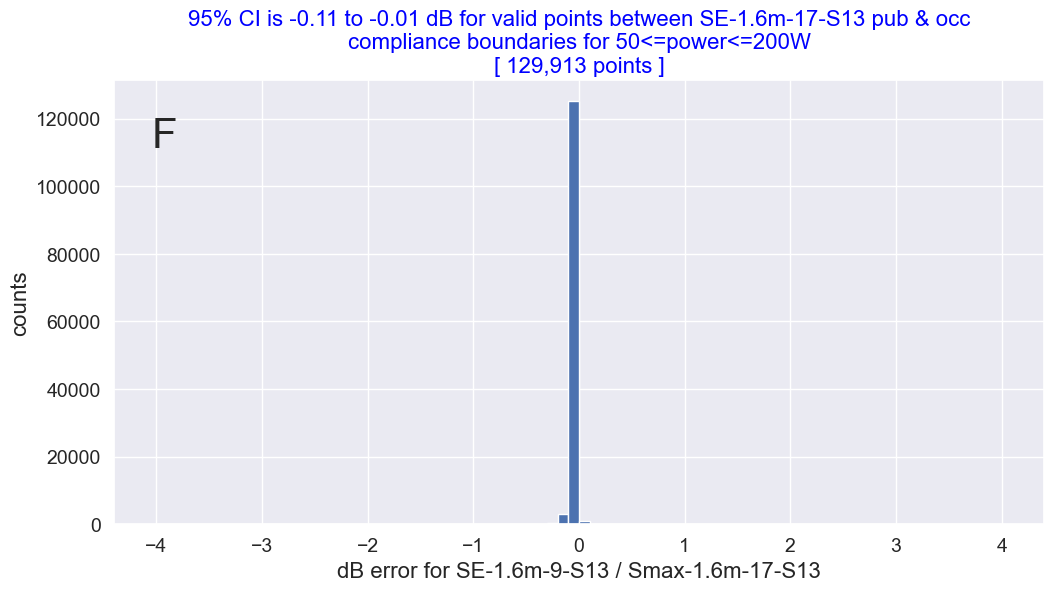

In [37]:
# fcb = f_Smax_cb50to200W_sa16
fcb = f_SE_cb50to200W_sa16_17_S13
for (Si1, Si2), letter in zip(Silist,LETTERS):
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=fcb, CI=95, bins=np.arange(-4,4.1,0.1))
    plt.gca().annotate(letter,(0.04,0.85),xycoords='axes fraction',fontsize=30)
    plt.savefig(plotdir + name + '.png', dpi=150)

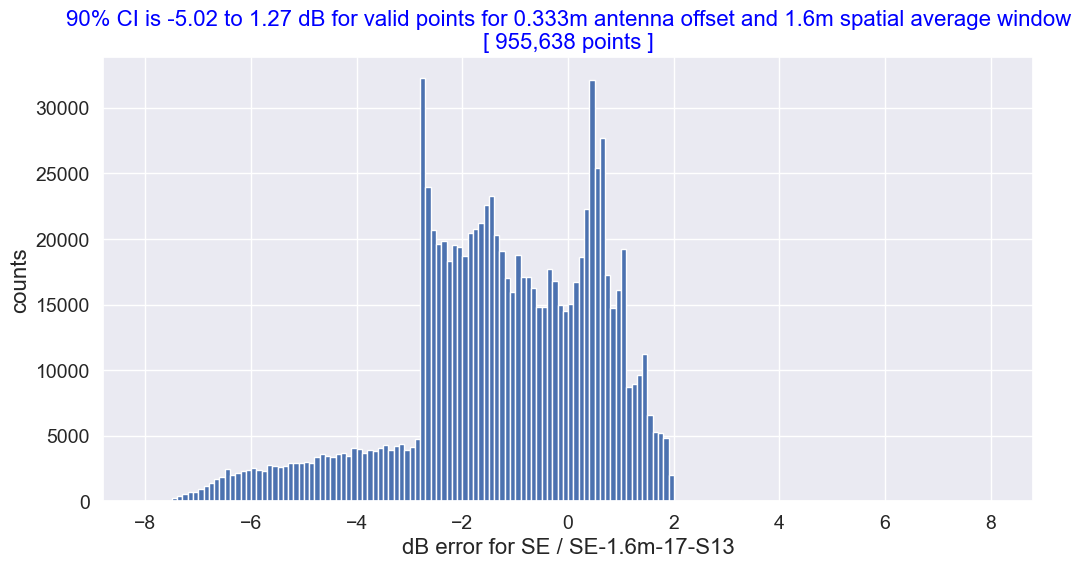

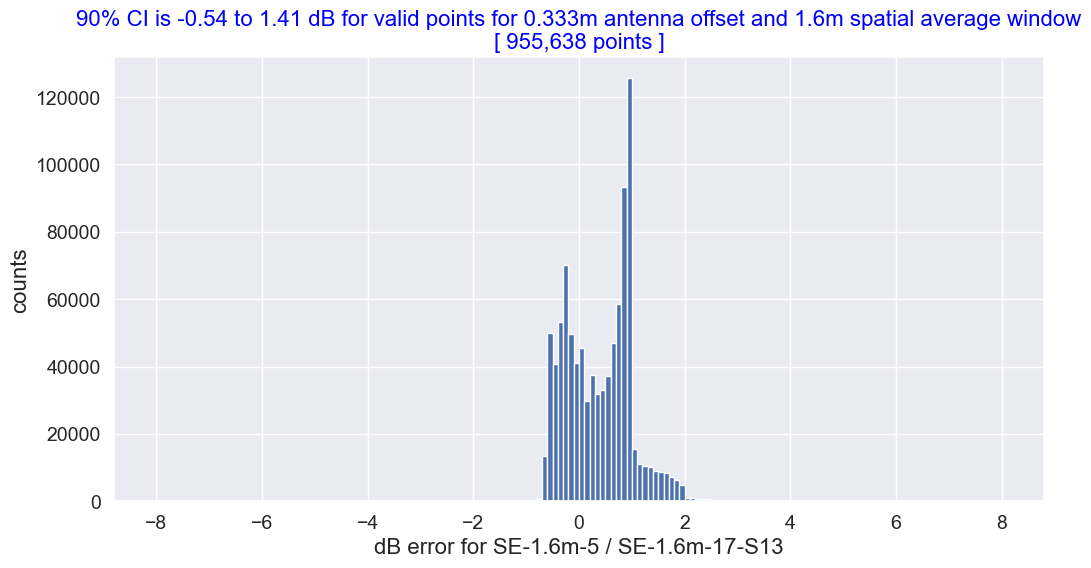

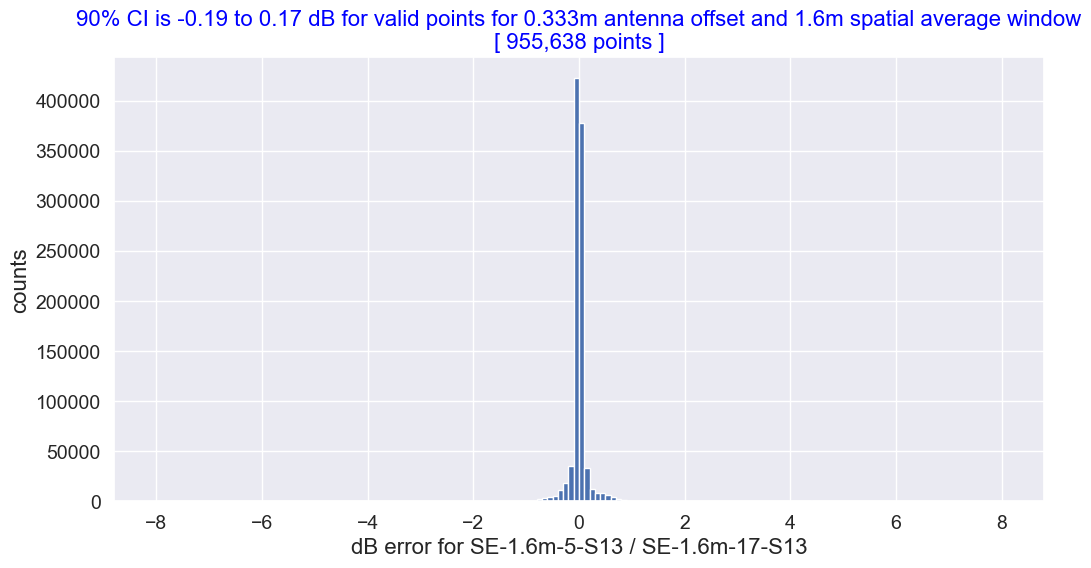

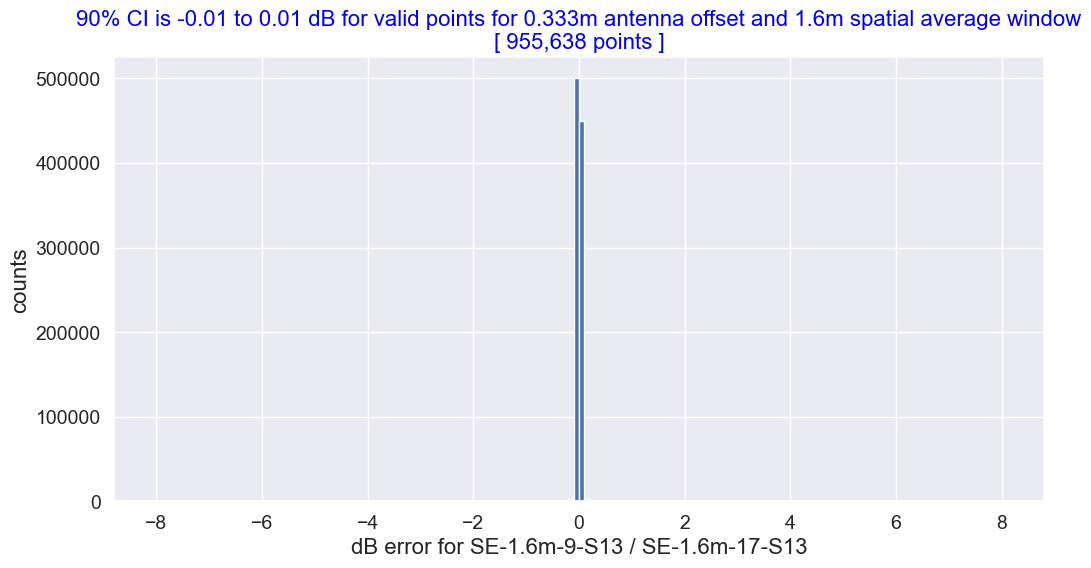

In [95]:
for (Si1, Si2) in Silist:
    name = f'dBerr {Si1} v {Si2}'
    R.hist(data=name, f=f_far_sa16, CI=90, bins=np.arange(-8,8.1,0.1))

In [207]:
showstats_dBerr(Silist, fcb)

Si   count  mean   std    min  2.5%   50%  97.5%   max
panel                                                                   
A                 SE  129913  0.04  1.77 -26.87 -4.92  0.66   1.80  1.96
B          SE-1.6m-3  129913 -0.51  0.81  -3.54 -1.44 -0.78   1.45  7.08
C          SE-1.6m-5  129913 -0.24  0.42  -3.10 -0.67 -0.38   0.80  4.90
D      SE-1.6m-3-S13  129913 -0.06  0.45  -3.23 -1.12  0.03   0.68  4.08
E      SE-1.6m-5-S13  129913 -0.03  0.14  -2.95 -0.37 -0.01   0.22  1.20
F      SE-1.6m-9-S13  129913 -0.03  0.06  -2.59 -0.11 -0.02  -0.01  0.22

## Uncertainty calcs

The triangular distribution can be represented with an up-sloping line from loc to (loc + c x scale) and then downsloping for (loc + c*scale) to (loc + scale).

triang takes c as a shape parameter for .

In [108]:
# Import scipy.stats modules
from scipy.stats import trapz, t, triang, norm, uniform

def norm_rvs(sigma,n):
    '''create random variate sample for normal distribution
       a = semi-span
       n = number of points'''
    rvs = norm.rvs(loc=0,scale=sigma,size=n)
    return rvs

def triang_rvs(a,n):
    '''create randon variate sample for symmetric trianguar distribution
       a = semi-span
       n = number of points'''
    rvs = triang.rvs(c=0.5, loc=-a, scale=2*a, size=n)
    return rvs

def uniform_rvs(a,n):
    '''create randon variate sample for symmetric uniform distribution
       a = semi-span
       n = number of points'''
    rvs = uniform.rvs(loc=-a,scale=2*a,size=n)
    return rvs


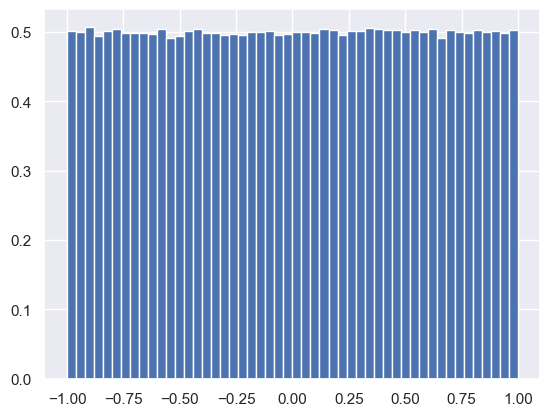

In [111]:
n = 1_000_000
Lx = triang.rvs(c=0.5, loc=-1, scale=2, size=n)
Lx = triang_rvs(1,n)
Lx = norm_rvs(1,n)
Lx = uniform_rvs(1,n) 
plt.hist(Lx,bins=50,density=True);

mean(Nps) = 0.631dB
U90 = [-2.96dB, 2.82dB]


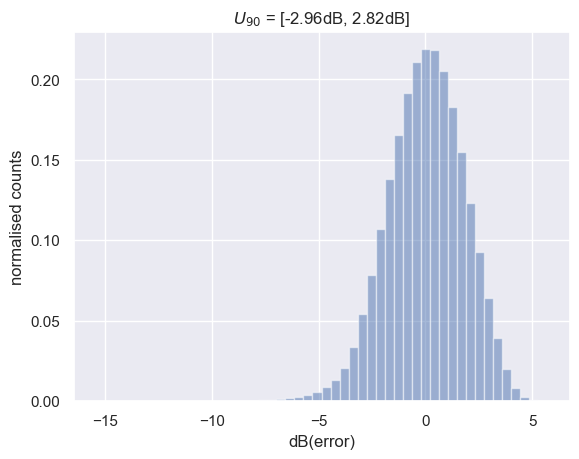

In [181]:
# Set context parameters
n = 1_000_000
f = f_sa16_cd50to200W
dBSerr = 'dBerr SE v SE-1.6m-5-S13'

# Generate the random variate samples 
# for the input quantities, xi
Ptx = norm_rvs(0.1,n)
Lx = triang_rvs(1,n)
Fs = 0
G = uniform_rvs(1.5,n) 
NFAC = uniform_rvs(2,n)
# Nps = norm_rvs(3.525,n)
Nps_data = R.S.loc[f.mask,'dBerr SE v SE-1.6m-5-S13']
Nps = np.random.choice(Nps_data, size=n, replace=True)
Nps_mean = Nps.mean()
Nps = Nps - Nps_mean
print(f'mean(Nps) = {Nps_mean:0.3f}dB')

# Create the combined dB distribution
# and calculate U95 percentiles
SeqdB = Ptx + Lx + Fs + G + NFAC + Nps
U95 = np.percentile(SeqdB, [2.5,97.5])
U90 = np.percentile(SeqdB, [5,95])
print(f"U90 = [{U90[0]:0.2f}dB, {U90[1]:0.2f}dB]")
plt.hist(SeqdB,bins=50,alpha=0.5,density=True)
plt.xlabel('dB(error)')
plt.ylabel('normalised counts')
plt.title("$U_{90}$" + f" = [{U90[0]:0.2f}dB, {U90[1]:0.2f}dB]");

In [87]:
# Import python modules
import numpy as np
from scipy.stats import trapz, t, triang, norm, uniform

# Set no. of M-C trials to 1 million
n = 1_000_000

# Generate the random variate samples 
# for the input quantities, xi
Ptx = norm.rvs(loc=0,scale=0.1,size=n)
Lx = triang.rvs(c=0.5, loc=-1, scale=2, size=n)
Fs = uniform.rvs(loc=-2,scale=4,size=n) 
G = uniform.rvs(loc=-1.5,scale=3,size=n) 
NFAC = uniform.rvs(loc=-2,scale=4,size=n)
Nps = norm.rvs(loc=0,scale=1.835,size=n)
Nps_data = R.S.loc[f_far_sa16.mask,'dBerr SE v SE-1.6m-5-S13']
Nps = np.random.choice(-Nps_data, size=n, replace=True)

# Create the combined dB distribution
# and calculate U95 percentiles
SeqdB = Ptx + Lx + Fs + G + NFAC + Nps
U95 = np.percentile(SeqdB, [2.5,97.5])
U90 = np.percentile(SeqdB, [5,95])
print(f"U90 = [{U90[0]:0.2f}dB, {U90[1]:0.2f}dB]")

U90 = [-2.93dB, 5.90dB]


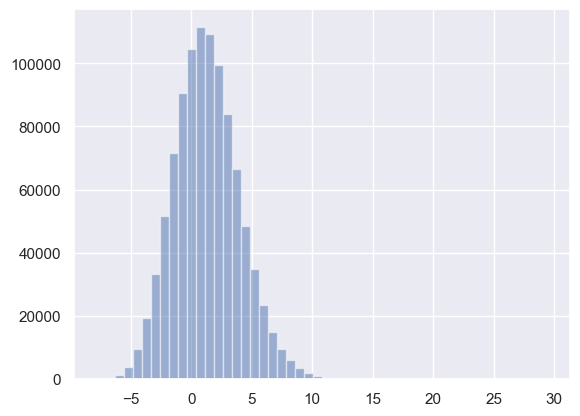

In [89]:
plt.hist(SeqdB,bins=50,alpha=0.5);

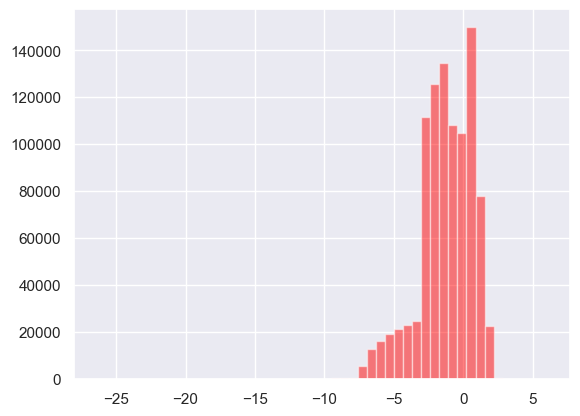

In [78]:
Nps = R.S.loc[f_sa16.mask,'dBerr SE v SE-1.6m-5-S13']
plt.hist(Nps,bins=50,alpha=0.5,color='red');

## Vertical S variations

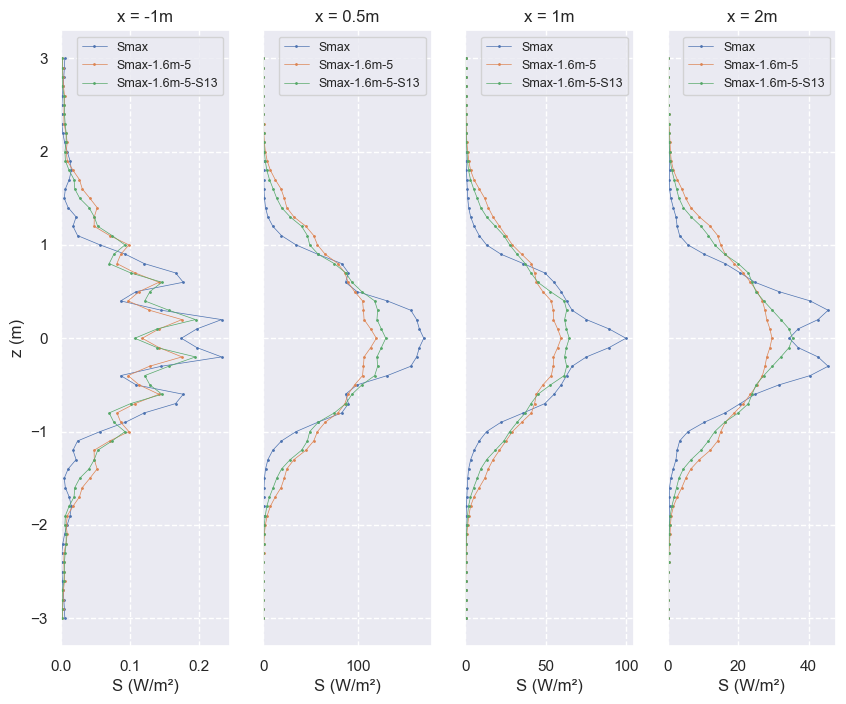

In [111]:
# Specify the S fields and x points to plot
xlist = [-1, 0.5, 1,2]
Slist = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13']

# Create the figure
fig, axes = plt.subplots(1,len(xlist),figsize=(10,8),sharey=True)
axes[0].set_ylabel('z (m)')

# Generate the plot lines
for ax, x in zip(axes,xlist):
    mask = (R.S.x == x) & (R.S.y == 0)
    s2 = R.S[mask]
    ax.set_title(f'x = {x}m')
    ax.set_xlabel('S (W/m²)')
    ax.grid(ls='--')
    for Si in Slist:
        ax.plot(s2[Si],s2.z,'o-',markersize=1,lw=0.5,label=Si)
    ax.legend(fontsize=9)
    ax.set_xlim(left=0)

## Save data to.csv file

In [59]:
R.S.columns

Index(['x', 'y', 'z', 'r', 'phi', 'SE', 'SH', 'Smax', 'SARwb', 'SARwbi',
       'SE-1.6m-17', 'Smax-1.6m-17', 'SE-1.6m-9', 'Smax-1.6m-9', 'SE-1.6m-5',
       'Smax-1.6m-5', 'SE-1.6m-3', 'Smax-1.6m-3', 'SE-1.6m-3-S13',
       'Smax-1.6m-3-S13', 'SE-1.6m-5-S13', 'Smax-1.6m-5-S13', 'SE-1.6m-9-S13',
       'Smax-1.6m-9-S13', 'SE-1.6m-17-S13', 'Smax-1.6m-17-S13',
       'SH-1.6m-5-S13', 'Smax SARwbi compliance ratio',
       'dB Smax SARwbi compliance ratio',
       'Smax-1.6m-17-S13 SARwbi compliance ratio',
       'dB Smax-1.6m-17-S13 SARwbi compliance ratio',
       'Smax-1.6m-3 SARwbi compliance ratio',
       'dB Smax-1.6m-3 SARwbi compliance ratio',
       'Smax-1.6m-5 SARwbi compliance ratio',
       'dB Smax-1.6m-5 SARwbi compliance ratio',
       'Smax-1.6m-3-S13 SARwbi compliance ratio',
       'dB Smax-1.6m-3-S13 SARwbi compliance ratio',
       'Smax-1.6m-5-S13 SARwbi compliance ratio',
       'dB Smax-1.6m-5-S13 SARwbi compliance ratio',
       'Smax-1.6m-9-S13 SARwbi complianc

In [60]:
cols = ['x', 'y', 'z', 'SE', 'SH', 'Smax', 'SARwb', 'SARwbi',
        'SE-1.6m-5', 'Smax-1.6m-5', 'SE-1.6m-5-S13','Smax-1.6m-5-S13', 
        'SE-1.6m-17', 'Smax-1.6m-17','SE-1.6m-17-S13', 'Smax-1.6m-17-S13']
R.S[cols].to_csv('../antennas/MBSpanel_2/data/MBS_panel_data_all.csv')

In [61]:
mask = (R.S.y >= 0)
R.S.loc[mask,cols].to_csv('../antennas/MBSpanel_2/data/MBS_panel_data_y_GE_0.csv')
R.S.loc[mask,cols]

x    y    z        SE        SH      Smax  SARwb  SARwbi  \
4270     -1.0  0.0 -3.0  0.005231  0.005397  0.005397    NaN     NaN   
4271     -1.0  0.0 -2.9  0.004599  0.004737  0.004737    NaN     NaN   
4272     -1.0  0.0 -2.8  0.003795  0.003878  0.003878    NaN     NaN   
4273     -1.0  0.0 -2.7  0.002860  0.002854  0.002860    NaN     NaN   
4274     -1.0  0.0 -2.6  0.001890  0.001757  0.001890    NaN     NaN   
...       ...  ...  ...       ...       ...       ...    ...     ...   
1298746  14.0  7.0  2.6  0.063321  0.062714  0.063321    NaN     NaN   
1298747  14.0  7.0  2.7  0.054166  0.053716  0.054166    NaN     NaN   
1298748  14.0  7.0  2.8  0.048698  0.048395  0.048698    NaN     NaN   
1298749  14.0  7.0  2.9  0.045836  0.045667  0.045836    NaN     NaN   
1298750  14.0  7.0  3.0  0.044632  0.044577  0.044632    NaN     NaN   

         SE-1.6m-5  Smax-1.6m-5  SE-1.6m-5-S13  Smax-1.6m-5-S13  SE-1.6m-17  \
4270      0.001905     0.001938       0.001702         0.001730    0.001383   
4271      0.002141     0.002168       0.001541         0.001564    0.001679   
4272      0.002625     0.002679       0.001573         0.001602    0.002190   
4273      0.003173     0.003383       0.001813         0.001900    0.002895   
4274      0.004545     0.004918       0.003960         0.004157    0.003672   
...            ...          ...            ...              ...         ...   
1298746   0.136183     0.136183       0.113471         0.113471    0.113647   
1298747   0.102191     0.102191       0.078350         0.078350    0.089424   
1298748   0.081975     0.081975       0.062588         0.062588    0.069909   
1298749   0.066050     0.066050       0.050678         0.050678    0.054398   
1298750   0.053826     0.053826       0.041977         0.041977    0.042217   

         Smax-1.6m-17  SE-1.6m-17-S13  Smax-1.6m-17-S13  
4270         0.001405        0.001326          0.001348  
4271         0.001702        0.001667          0.001693  
4272         0.002223        0.001977          0.002003  
4273         0.002991        0.002745          0.002809  
4274         0.003867        0.003433          0.003585  
...               ...             ...               ...  
1298746      0.113647        0.106971          0.106971  
1298747      0.089424        0.084722          0.084722  
1298748      0.069909        0.065252          0.065252  
1298749      0.054398        0.051523          0.051523  
1298750      0.042217        0.039145          0.039145  

[653981 rows x 16 columns]

In [62]:
for key, item in R.datatitles.items():
    print(f'{key}:  {item}')

SE:  S(E) levels
SH:  S(H) levels
Smax:  Smax levels
SARps:  peak spatial SAR
SARwb:  WBA SAR
SARwbi:  WBA SAR (interpolated)
SE-1.6m-17:  FEKO SE levels (17 points averaged over 1.6m)
Smax-1.6m-17:  FEKO Smax levels (17 points averaged over 1.6m)
SE-1.6m-9:  FEKO SE levels (9 points averaged over 1.6m)
Smax-1.6m-9:  FEKO Smax levels (9 points averaged over 1.6m)
SE-1.6m-5:  FEKO SE levels (5 points averaged over 1.6m)
Smax-1.6m-5:  FEKO Smax levels (5 points averaged over 1.6m)
SE-1.6m-3:  FEKO SE levels (3 points averaged over 1.6m)
Smax-1.6m-3:  FEKO Smax levels (3 points averaged over 1.6m)
SE-1.6m-3-S13:  FEKO SE levels (3 points averaged over 1.6m (Simpson 1/3))
Smax-1.6m-3-S13:  FEKO Smax levels (3 points averaged over 1.6m (Simpson 1/3))
SE-1.6m-5-S13:  FEKO SE levels (5 points averaged over 1.6m (Simpson 1/3))
Smax-1.6m-5-S13:  FEKO Smax levels (5 points averaged over 1.6m (Simpson 1/3))
SE-1.6m-9-S13:  FEKO SE levels (9 points averaged over 1.6m (Simpson 1/3))
Smax-1.6m-9-S13

## Image of compliance zone and points

In [44]:
Ssa = 'dB Smax-1.6m-5-S13 SARwbi compliance ratio'
Ssa = 'Smax'
f = deepcopy(f_Smax_cb50to200W)
f.mask = f.mask & (R.S.y <= 0)

R.msp(data=Ssa,f=f,mp=1,V=[0,90],nlabels=10,ncolors=9, scale=0.1,
      antenna=RFcalcUC.panelAntenna,ctitle='Smax',standard='RPS S-1 WB')

In [221]:
# 3D view of public exclusion zone (200W) and enclosing SARwbi 'box of points'
R.ExclusionZone(
    data=["SE"],
    power=[200],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="", #RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    gridpoints=True,
    gridpoint_filter=f_SARwbi,
    axv=[True,True,True],
    bg='white',
)

dat='SE', con=4.5
[-0.1, 12.8, -5.8, 5.8, -1.3, 1.3]
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500


In [47]:
sflist = [['Smax',f_Smax_cb50to200W],
          ['Smax-1.6m-17-S13',f_Smax_cb50to200W_sa16_17_S13],
          ['Smax-1.6m-3',f_Smax_cb50to200W_sa16_3],
          ['Smax-1.6m-5',f_Smax_cb50to200W_sa16_5],
          ['Smax-1.6m-3-S13',f_Smax_cb50to200W_sa16_3_S13],
          ['Smax-1.6m-5-S13',f_Smax_cb50to200W_sa16_5_S13],
          ['Smax-1.6m-9-S13',f_Smax_cb50to200W_sa16_9_S13],
          ['SE-1.6m-5-S13',f_Smax_cb50to200W_sa16_5_S13]]

# 3D view of public (200W) and occ (50W) exclusions zones
i = 7
Si = sflist[i][0]
f = sflist[i][1]
print(Si)

R.ExclusionZone(
    data=[Si, Si],
    power=[200,50],
    color=["gold", "red"],
    alpha=[1, 1],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title=f"RPS S-1 public (200 W) and occupational (50W) exclusion zones for {Si}",
    figsize=(1200,800),
    gridpoints=True,
    gridpoint_filter=f,
    gridpoint_size=0.04,
    gridpoint_opacity=1,
    ycut=0,
    axv=[True,True,True],
    bg='white',
)

SE-1.6m-5-S13
dat='SE-1.6m-5-S13', con=4.5
dat='SE-1.6m-5-S13', con=90.0
[0.0, 11.6, -4.7, 4.7, -1.9, 1.9]
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500
power=200, plotpower=50, setting=occupational, limit=22.5 W/m², contour level=90.000


In [203]:
# Create plot of assessment point locations between compliance boundaries
f = f_Smax_cb50to200W
f.mask = f.mask & (R.S.y >= 0)
R.msp(data='Smax', f=f, mp=1, V=[0, 100], nlabels=6, ncolors=6,
            scale=0.075, antenna=RFcalcUC.panelAntenna, ctitle=None, standard='RPS S-1 WB')

In [101]:
# Show mask points
# f = f_near
# f = f_outant
# f = f_outant
f = f_Smax_cb50to200W
# f = f_not_sa16
# f = f_Smax_cb50to200W_sa16
# f = f_sa16
print(f.name)
RFcalcUC.show_grid_points(R.S[f.mask], fields=['SE'],hman=None,axv=(True,True,True), ycut=False,
                          antcolor='yellow',bgcolor='white',antenna=RFcalcUC.panelAntenna,title=f.name)

valid 1.6m points at Smax pub & occ compliance boundaries for 50<=power<=200W


## Scratch

$\Large S_{avg, z_0} = \frac{\int_{z_0-L/2}^{z_0+L/2}{S(z) dz}}{L} \quad \text{(eq. 1)}$

$\Large S_{avg} = \frac{[S_0 + S_1 + S_2 + S_3 + S_4 + S_5]}{5}$

$\Large S_{avg} = \frac{\Delta z}{L}[\frac{1}{2}S_0 + S_1 + S_2 + S_3 + S_4 + \frac{1}{2}S_5]$

$\Large S_{avg} = \frac{\Delta z}{3L}[S_0 + 4S_1 + 2S_2 + 2S_3 + 4S_4 + S_5]$

In [41]:
def skewGrid():
    '''Show S and SAR grid points
    usage: .showgrids(S, SAR)
      S = flag to toggle S grid visibility (True/False)
    SAR = flag to toggle SAR grid visibility (True/False)
    hman = height of body model behind antenna in m
           If hman = None, then man model is not displayed
    avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
    '''
    # Make the grid
    x = [-0.8,-0.3,0.2, 0.5, 0.8, 1.3, 2, 3.2, 5, 7.3, 10, 13]
    y = [0, 0.3, 0.8, 1.6, 2.6, 4, 6]
    z = [-2,-1, 0, 1, 2]    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(900,900), bgcolor=(0.3, 0.3, 0.3))
    mlab.clf()

    # draw the SAR grid popints
    mlab.points3d(xx,yy,zz,scale_factor=0.1,color=(1,1,0),opacity=1)   # SAR grid

    # Add the antenna box
    RFcalcUC.panelAntenna('yellow')

    # Draw the scene
    fig.scene.parallel_projection = True
    mlab.show()
    
skewGrid()

In [117]:
txt = "The man sat on a long bridge while contemplating his very existence in this strange but beautiful world"
txt2 = tr.fill(txt, 80)
print(txt2)

The man sat on a long bridge while contemplating his very existence in this
strange but beautiful world


In [42]:
a = pd.Series([1,2,3,np.nan])
display(a)
a.mean()

0    1.0
1    2.0
2    3.0
3    NaN
dtype: float64

2.0

KstestResult(statistic=0.02695698665017554, pvalue=0.45373481183512343)

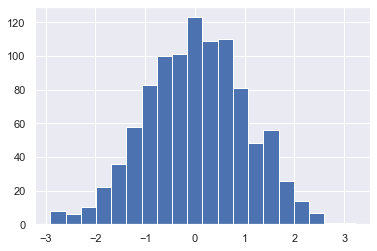

In [263]:
import numpy as np
from scipy import stats
np.random.seed(9)

my_data = stats.norm.rvs(size=1000)
plt.hist(my_data,bins=20);
stats.kstest(my_data, 'norm')

In [22]:
R.S['SARwbi'].dropna().size

689579

### Mayavi animations

In [4]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

In [2]:
import numpy as np
from mayavi import mlab
x, y = np.mgrid[0:3:1,0:3:1]
s = mlab.surf(x, y, np.asarray(x*0.1, 'd'))

@mlab.animate
def anim():
    for i in range(10):
        s.mlab_source.scalars = np.asarray(x*0.1*(i+1), 'd')
        yield

anim()
mlab.show()

In [6]:
# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

# View it.
l = mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')

# Now animate the data.
ms = l.mlab_source
for i in range(10):
    x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer + np.pi*(i+1)/5.)*0.5)
    scalars = np.sin(mu + np.pi*(i+1)/5)
    ms.trait_set(x=x, scalars=scalars)
    
mlab.show()

In [8]:
from mayavi import mlab
@mlab.animate(delay=100, ui=False)
def anim():
    f = mlab.gcf()
    while 1:
        f.scene.camera.azimuth(2)
        f.scene.render()
        yield

a = anim() # Starts the animation.
mlab.show()

In [10]:
import numpy as np
from mayavi import mlab

@mlab.animate(delay = 100)
def updateAnimation():
    t = 0.0
    while True:
        ball.mlab_source.set(x = np.cos(t), y = np.sin(t), z = 0)
        t += 0.1
        yield

ball = mlab.points3d(np.array(1.), np.array(0.), np.array(0.))

updateAnimation()
mlab.show()

In [29]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

@mlab.animate(delay = 50)
def updateAnimation():
    az = 0.0
    while True:
        mlab.view(azimuth=az, elevation=70,distance=10)
        az += 1
        yield

# View it.
fig = mlab.figure(1, size=(900,900), bgcolor=(1,1,1))
mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')
updateAnimation()
mlab.show()

### Fast start

In [8]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# Set trial number
trial = 2
t = trials[str(trial)]

# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)

# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print()
print(*R.grid.items(),sep='\n')
print()
R.S.info()

datadir = '../antennas/MBSpanel_2/data/'
plotdir = '../antennas/MBSpanel_2/plots/'
Sfile='../antennas/MBSpanel_2/data/MBSpanel_2.hdf5'


x    y    z         r        phi        SE        SH      Smax  SARwb  \
0 -1.0 -7.0 -3.0  7.071068 -98.130102  0.007138  0.007219  0.007219    NaN   
1 -1.0 -7.0 -2.9  7.071068 -98.130102  0.007635  0.007725  0.007725    NaN   
2 -1.0 -7.0 -2.8  7.071068 -98.130102  0.007646  0.007729  0.007729    NaN   
3 -1.0 -7.0 -2.7  7.071068 -98.130102  0.007189  0.007244  0.007244    NaN   
4 -1.0 -7.0 -2.6  7.071068 -98.130102  0.006404  0.006415  0.006415    NaN   

   SARwbi  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}


('x', [-1, 14, 0.1])
('y', [-7, 7, 0.1])
('z', [-3, 3, 0.1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298751 entries, 0 to 1298750
Data columns (total 10 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1298751 non-null  float64
 1   y       1298751 non-null  float64
 2   z       1298751 non-null  float64
 3   r       1298751 non-null  float64
 4   phi     1298751 non-null  float64
 5   SE      1298751 non-null  float64
 6   SH      1298751 non-null  float64
 7   Smax    1298751 non-null  float64
 8   SARwb   780 non-null      float64
 9   SARwbi  689579 non-null   float64
dtypes: float64(10)
memory usage: 99.1 MB


In [107]:
# test filter options
fname = 'outant'
fname = 'spatavg_outant'
fname = 'all'
fname = 'ant'
fname = 'cb'
fname = 'icb'

f = R.sf(fname,offset=0.7,spatavgL=1.6)
df = R.S[f.mask]
RFcalcUC.show_grid_points(df, fields=['Smax'],hman=1.6,axv=(True,True,True),
                          antenna=RFcalcUC.panelAntenna,title='')

In [2]:
ff = [['a',1],['b',2],['c',3]]
for l, n in ff:
    print(l,n)

a 1
b 2
c 3


$u(x_i)=(b-a)\sqrt{\frac{\alpha\beta}{\alpha+\beta+1)(\alpha+\beta)^2)}}$

$\alpha=\frac{2(b+4m-5a)(1+4(m-a)(b-m)/(b-a)^2)}{3(b-a)}$

$\beta=\frac{2(5b-4m-a)(1+4(m-a)(b-m)/(b-a)^2)}{3(b-a)}$

$y=\bar{Y}=\frac{1}{n}\sum_{j=1}^{n}f\left(X_{1,j},X_{2,j},\cdots,X_{N,j}\right)$

$u_c^2(y)=\sum_{i=1}^{N}{(\frac{\partial f}{\partial x_i})^2u^2(x_i)}+\sum_{i=1}^{N}{\sum_{j=1}^{N}(\frac{1}{2}(\frac{\partial^2f}{\partial x_i\partial x_j})^2+\frac{\partial f}{\partial x_i}\frac{\partial^3f}{\partial x_i{\partial x}_j^2})u^2(x_i)u^2(x_i)}$

$y=\bar{Y}=\frac{1}{n}\sum_{j=1}^{n}f(X_{1,j},X_{2,j},\cdots,X_{N,j})$

$\frac{Y}{y}=\frac{X_1X_2X_3}{x_1x_2x_3}$

$\begin{eqnarray}\frac{Y}{y}&=&\frac{X_1X_2X_3}{x_1x_2x_3}\quad\quad\text{(Eq. }\textbf{7}\text{)}\\
10{log}_{10}{\left(\frac{Y}{y}\right)}&=&10{log}_{10}{\left(\frac{X_1}{x_1}\frac{X_2}{x_2}\frac{X_3}{x_3}\right)}\\
&=&10{log}_{10}{\left(\frac{X_1}{x_1}\right)+}10{log}_{10}{\left(\frac{X_1}{x_1}\right)+}10{log}_{10}{\left(\frac{X_1}{x_1}\right)}\quad\quad\text{(Eq. }\textbf{8}\text{)}\\
dB(Y)&=&dB(X_1)+dB(X_2)+dB(X_3)\quad\quad\text{(Eq. }\textbf{9}\text{)}\end{eqnarray}$

$\left[u_c(y)/y\right]^2$

$\left[u(x_i)/x_i\right]^2$

$\left[\frac{u_c\left(y\right)}{y}\right]^2=\sum_{i=1}^{N}\left[\frac{p_iu\left(x_i\right)}{x_i}\right]^2$

$u_i(y)=|c_i|u(x_i)$

$\Delta u(x_i) / u(x_i)$

$u_P=\frac{1}{2}\left(0.5-\left(-0.5\right)\right)/\sqrt{3}=$

$\begin{eqnarray} u_d &=& \sqrt{\left({0.1}^2+0+{0.1}^2-0-\left({-0.1}^2\right)-0\right)/18}\\
&=&\sqrt{3\left({0.1}^2\right)/18}=\sqrt{{0.1}^2/6}=0.1/\sqrt6=\mathbf{0}.\mathbf{041}\end{eqnarray}$

$u_G=(17.9\% + 15.2\%)/2 = 16.5\%$

$\huge S_{avg}=\frac{S_1+S_2+S_3+S_4}{4}$